<a href="https://colab.research.google.com/github/yuliavincentia/NLP-Project/blob/main/Summary_Yulia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install Depedencies


In [ ]:
!pip install -q datasets transformers nltk matplotlib seaborn pandas numpy tqdm sentencepiece sacrebleu rouge-score

# Mount Google Drive dan Extract Dataset


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
"/content/drive/MyDrive/Bootcamp/project2/liputan6_data.tar.gz"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/Bootcamp/project2/liputan6_data.tar.gz'

In [ ]:
# Setup paths dan ekstrak dataset
import os

# Path ke file tar.gz di Drive
DRIVE_FILE = "/content/drive/MyDrive/Bootcamp/project2/liputan6_data.tar.gz"

# Buat folder untuk ekstraksi di Colab (bukan di Drive)
!mkdir -p /content/data/dataset/

# Copy dan ekstrak dataset
print("Copying and extracting dataset...")
!cp "{DRIVE_FILE}" /content/data/
!cd /content/data && tar -xzf liputan6_data.tar.gz -C dataset/

Copying and extracting dataset...


In [ ]:
from datasets import load_dataset, Dataset, DatasetDict
# Cek hasil ekstraksi
print("\nIsi folder hasil ekstraksi:")
!ls -l /content/data/dataset/liputan6_data/


# Load dataset
dataset = load_dataset(
    "id_liputan6",
    name="canonical",
    data_dir="/content/data/dataset/liputan6_data/",
    trust_remote_code=True
)

# Verifikasi dataset
print("\nDataset splits:", dataset.keys())
for split in dataset.keys():
    print(f"{split} size:", len(dataset[split]))


Isi folder hasil ekstraksi:
total 704
-rw-r--r-- 1 1001 1001 712251 Nov 30  2020 AACL2020-Liputan6.pdf
drwxr-xr-x 5 1001 1001   4096 Nov 30  2020 canonical
drwxr-xr-x 4 1001 1001   4096 Nov 30  2020 xtreme


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



Dataset splits: dict_keys(['validation', 'test', 'train'])
validation size: 10972
test size: 10972
train size: 193883


In [ ]:
# Periksa struktur folder setelah ekstraksi
!ls -R /content/data/dataset/liputan6_data/

# Coba cara alternatif untuk load dataset
from datasets import load_from_disk, load_dataset
import json

# Cek apakah ada file dataset_dict.json
!find /content/data/dataset/liputan6_data/ -name "dataset_dict.json"

# Coba load dengan path absolut
import os
DATA_PATH = os.path.abspath("/content/data/dataset/liputan6_data/")
print(f"\nPath absolut: {DATA_PATH}")

Output streaming akan dipotong hingga 5000 baris terakhir.
135645.json  173090.json  207442.json  244516.json  280748.json  46510.json   93764.json
135646.json  173091.json  207443.json  244518.json  280749.json  46511.json   93765.json
135647.json  173092.json  207444.json  244519.json  280750.json  46512.json   93767.json
135648.json  173093.json  207445.json  244523.json  280751.json  46513.json   93768.json
135649.json  173094.json  207446.json  244524.json  280754.json  46514.json   93769.json
135650.json  173098.json  207447.json  244525.json  280755.json  46516.json   93770.json
135651.json  173099.json  207448.json  244526.json  280756.json  46517.json   93772.json
135652.json  173100.json  207449.json  244527.json  280757.json  46518.json   93773.json
135653.json  173101.json  207450.json  244531.json  280758.json  46519.json   93774.json
135654.json  173102.json  207451.json  244532.json  280759.json  46520.json   93775.json
135655.json  173103.json  207452.json  244533.json 

# Data Explore & Preprocessing

## Setup awal & Checking

In [ ]:
import os
import re
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm.auto import tqdm
import glob

# Set seed untuk reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Path dataset
DATA_PATH = "/content/data/dataset/liputan6_data"
print(f"Path dataset: {DATA_PATH}")

# Fungsi untuk meload file jsonl
def load_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return data

# Fungsi untuk meload file json
def load_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

# Fungsi untuk memuat semua file JSON dalam direktori
def load_all_json_files(directory):
    print(f"Loading files from directory: {directory}")
    data = []

    # Cari semua file JSON dan JSONL di direktori tersebut
    json_files = glob.glob(os.path.join(directory, "*.json"))
    jsonl_files = glob.glob(os.path.join(directory, "*.jsonl"))
    all_files = json_files + jsonl_files

    print(f"Found {len(all_files)} JSON/JSONL files in {directory}")

    for file_path in all_files:
        try:
            ext = os.path.splitext(file_path)[1].lower()
            if ext == '.jsonl':
                file_data = load_jsonl(file_path)
                print(f"Loaded JSONL file: {file_path} with {len(file_data)} examples")
            elif ext == '.json':
                file_data = load_json(file_path)
                if not isinstance(file_data, list):
                    file_data = [file_data]  # Pastikan hasilnya adalah list
                print(f"Loaded JSON file: {file_path} with {len(file_data)} examples")

            data.extend(file_data)
        except Exception as e:
            print(f"Error loading file {file_path}: {e}")

    return data

# Path ke direktori yang berisi data
train_path = os.path.join(DATA_PATH, "canonical", "train")
val_path = os.path.join(DATA_PATH, "xtreme", "dev")
test_path = os.path.join(DATA_PATH, "xtreme", "test")

# Memuat dataset
dataset = {}

print("\n=== MEMUAT DATASET ===")

# Cek dan muat train data dari canonical/train
if os.path.exists(train_path) and os.path.isdir(train_path):
    print(f"\nMemuat train data dari {train_path}...")
    dataset['train'] = load_all_json_files(train_path)
    print(f"Berhasil memuat {len(dataset.get('train', []))} contoh train")
else:
    print(f"Directory tidak ditemukan: {train_path}")
    dataset['train'] = []

# Cek dan muat validation data dari xtreme/dev
if os.path.exists(val_path) and os.path.isdir(val_path):
    print(f"\nMemuat validation data dari {val_path}...")
    dataset['validation'] = load_all_json_files(val_path)
    print(f"Berhasil memuat {len(dataset.get('validation', []))} contoh validation")
else:
    print(f"Directory tidak ditemukan: {val_path}")
    dataset['validation'] = []

# Cek dan muat test data dari xtreme/test
if os.path.exists(test_path) and os.path.isdir(test_path):
    print(f"\nMemuat test data dari {test_path}...")
    dataset['test'] = load_all_json_files(test_path)
    print(f"Berhasil memuat {len(dataset.get('test', []))} contoh test")
else:
    print(f"Directory tidak ditemukan: {test_path}")
    dataset['test'] = []

# Periksa hasil loading dataset
print("\n=== HASIL LOADING DATASET ===")
for split in dataset:
    print(f"Split: {split}, Jumlah: {len(dataset[split])}")
    if dataset[split]:
        print(f"Contoh pertama: {dataset[split][0]}")
        # Cetak struktur item data
        print(f"Keys: {list(dataset[split][0].keys()) if isinstance(dataset[split][0], dict) else 'Bukan dictionary'}")
    print("-" * 40)

# Jika masih tidak berhasil memuat data, coba pendekatan lain - cari file langsung di direktori
if not dataset or sum(len(dataset.get(split, [])) for split in ['train', 'validation', 'test']) == 0:
    print("\nMencoba alternatif: Mencari file JSON secara langsung...")

    train_files = glob.glob(os.path.join(train_path, "**", "*.json"), recursive=True)
    train_files += glob.glob(os.path.join(train_path, "**", "*.jsonl"), recursive=True)

    val_files = glob.glob(os.path.join(val_path, "**", "*.json"), recursive=True)
    val_files += glob.glob(os.path.join(val_path, "**", "*.jsonl"), recursive=True)

    test_files = glob.glob(os.path.join(test_path, "**", "*.json"), recursive=True)
    test_files += glob.glob(os.path.join(test_path, "**", "*.jsonl"), recursive=True)

    print(f"Ditemukan {len(train_files)} file di train, {len(val_files)} file di validation, {len(test_files)} file di test")

    # Coba muat masing-masing file
    dataset = {'train': [], 'validation': [], 'test': []}

    for file_path in train_files:
        try:
            ext = os.path.splitext(file_path)[1].lower()
            if ext == '.jsonl':
                data = load_jsonl(file_path)
            elif ext == '.json':
                data = load_json(file_path)
                if not isinstance(data, list):
                    data = [data]
            dataset['train'].extend(data)
            print(f"Loaded {file_path}, {len(data)} examples")
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    for file_path in val_files:
        try:
            ext = os.path.splitext(file_path)[1].lower()
            if ext == '.jsonl':
                data = load_jsonl(file_path)
            elif ext == '.json':
                data = load_json(file_path)
                if not isinstance(data, list):
                    data = [data]
            dataset['validation'].extend(data)
            print(f"Loaded {file_path}, {len(data)} examples")
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    for file_path in test_files:
        try:
            ext = os.path.splitext(file_path)[1].lower()
            if ext == '.jsonl':
                data = load_jsonl(file_path)
            elif ext == '.json':
                data = load_json(file_path)
                if not isinstance(data, list):
                    data = [data]
            dataset['test'].extend(data)
            print(f"Loaded {file_path}, {len(data)} examples")
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    print("\n=== HASIL LOADING ALTERNATIF ===")
    for split in dataset:
        print(f"Split: {split}, Jumlah: {len(dataset[split])}")
        if dataset[split]:
            print(f"Contoh pertama: {dataset[split][0]}")
            # Cetak struktur item data
            print(f"Keys: {list(dataset[split][0].keys()) if isinstance(dataset[split][0], dict) else 'Bukan dictionary'}")
        print("-" * 40)


Output streaming akan dipotong hingga 5000 baris terakhir.
Loaded JSON file: /content/data/dataset/liputan6_data/xtreme/dev/827.json with 1 examples
Loaded JSON file: /content/data/dataset/liputan6_data/xtreme/dev/8788.json with 1 examples
Loaded JSON file: /content/data/dataset/liputan6_data/xtreme/dev/4248.json with 1 examples
Loaded JSON file: /content/data/dataset/liputan6_data/xtreme/dev/1056.json with 1 examples
Loaded JSON file: /content/data/dataset/liputan6_data/xtreme/dev/6038.json with 1 examples
Loaded JSON file: /content/data/dataset/liputan6_data/xtreme/dev/446.json with 1 examples
Loaded JSON file: /content/data/dataset/liputan6_data/xtreme/dev/5963.json with 1 examples
Loaded JSON file: /content/data/dataset/liputan6_data/xtreme/dev/6288.json with 1 examples
Loaded JSON file: /content/data/dataset/liputan6_data/xtreme/dev/3367.json with 1 examples
Loaded JSON file: /content/data/dataset/liputan6_data/xtreme/dev/4107.json with 1 examples
Loaded JSON file: /content/data/d

## Analisis Data



=== ANALISIS DATASET ===


Mempersiapkan data untuk analisis:   0%|          | 0/500 [00:00<?, ?it/s]


=== STATISTIK PANJANG TEKS ===

Artikel (Token):
  Mean: 237.57
  Median: 195.00
  Min: 75.00
  Max: 1517.00
  Std: 147.05

Ringkasan Abstraktif (Token):
  Mean: 31.34
  Median: 30.00
  Min: 12.00
  Max: 88.00
  Std: 8.02

Ringkasan Ekstraktif (Token):
  Mean: 43.46
  Median: 43.00
  Min: 18.00
  Max: 89.00
  Std: 11.96


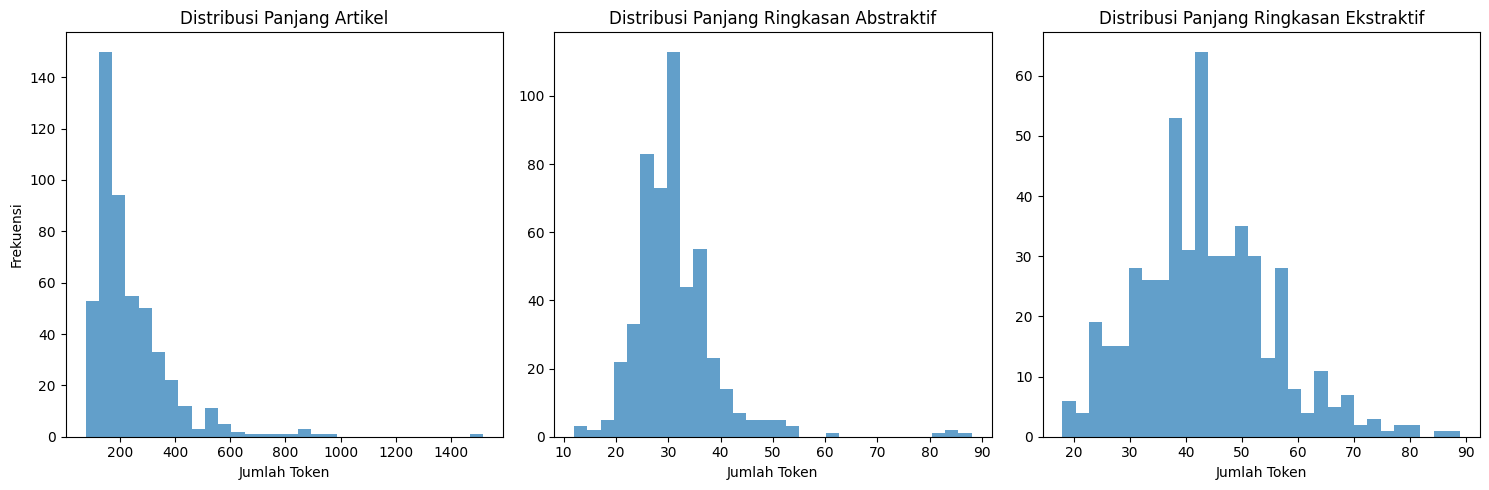


=== ANALISIS COMPRESSION RATIO ===
Rata-rata compression ratio: 0.1665
Median compression ratio: 0.1474
Min compression ratio: 0.0244
Max compression ratio: 0.8252


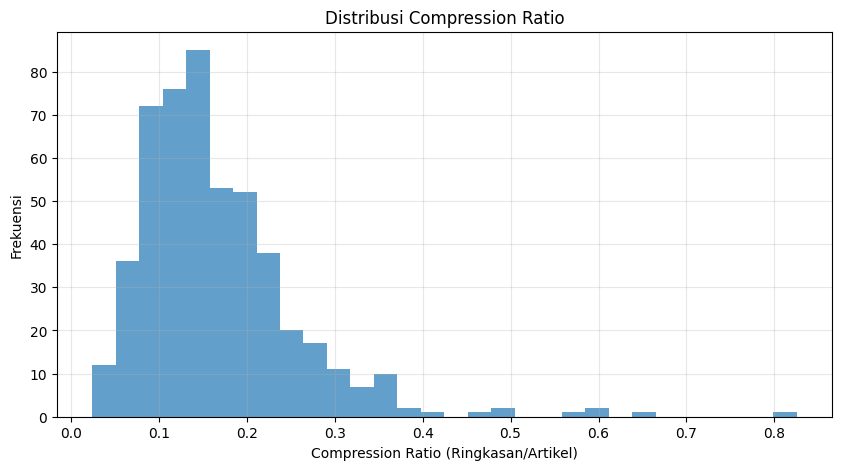


=== ANALISIS VOCABULARY ===
Analyzing article vocabulary...


Processing texts:   0%|          | 0/500 [00:00<?, ?it/s]


Analyzing summary vocabulary...


Processing texts:   0%|          | 0/500 [00:00<?, ?it/s]


Article Vocabulary Statistics:
Vocabulary size: 12,969
Total words: 101,123

Top 20 words in articles:
yang: 2,253
di: 2,226
dan: 1,743
ini: 1,052
itu: 894
dengan: 791
dari: 773
untuk: 693
dalam: 624
ke: 546
tidak: 464
jakarta: 464
juga: 461
akan: 459
com: 442
liputan6: 435
mereka: 398
tak: 396
pada: 353
warga: 330

Summary Vocabulary Statistics:
Vocabulary size: 4,704
Total words: 13,825

Top 20 words in summaries:
di: 360
dan: 246
yang: 242
ini: 100
untuk: 97
dari: 94
dengan: 92
ke: 87
dalam: 78
akan: 69
itu: 66
karena: 62
tak: 58
mereka: 58
warga: 52
tidak: 50
dua: 47
para: 47
jakarta: 45
pada: 42

=== ANALISIS NOVEL N-GRAMS ===
Calculating novel 4-grams...


Calculating novel 4-grams: 0it [00:00, ?it/s]

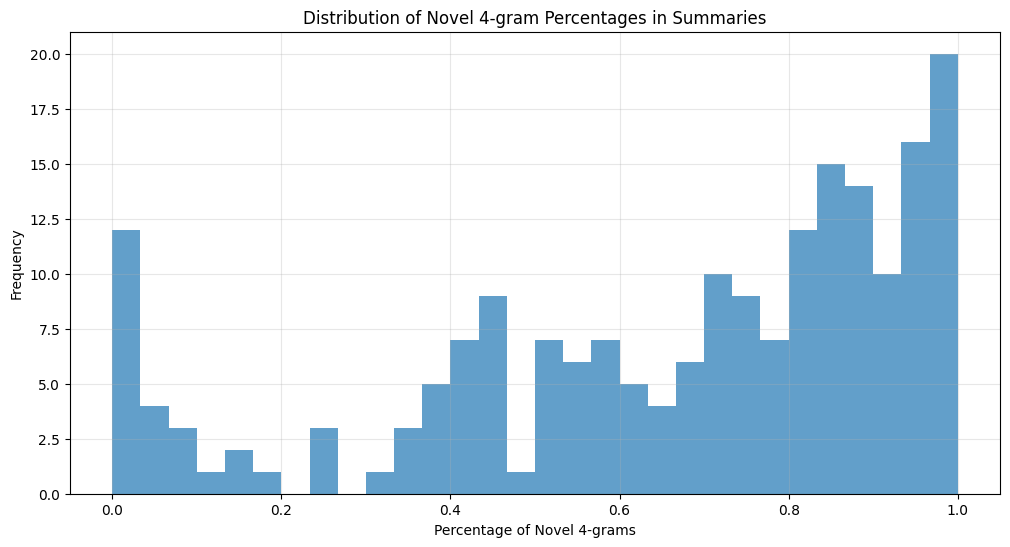


Novel 4-gram Statistics:
Mean: 0.660
Median: 0.750
Std: 0.294

Analisis dataset selesai!


In [ ]:
print("\n=== ANALISIS DATASET ===")

# Fungsi untuk mengkonversi berbagai format data menjadi teks
def convert_to_text(data):
    """Mengkonversi berbagai format data menjadi teks biasa"""
    if isinstance(data, list):
        if len(data) > 0 and all(isinstance(sentence, list) for sentence in data):
            # List of lists (kalimat berisi list token)
            return " ".join([" ".join([str(token) for token in sentence]) for sentence in data])
        else:
            # Simple list
            return " ".join([str(item) for item in data])
    else:
        # Sudah berupa string
        return str(data)

# Pastikan kita memiliki data untuk dianalisis
if not dataset or 'train' not in dataset or not dataset['train']:
    print("Tidak ada data yang cukup untuk analisis!")
else:
    # Ekstrak teks untuk analisis
    train_articles = []
    train_summaries = []
    train_extractive = []

    for item in tqdm(dataset['train'][:500], desc="Mempersiapkan data untuk analisis"):
        # Periksa kolom yang ada dan konversi ke teks
        if 'clean_article' in item and item['clean_article']:
            article_text = convert_to_text(item['clean_article'])
        elif 'article' in item and item['article']:
            article_text = convert_to_text(item['article'])
        else:
            article_text = "Artikel tidak tersedia"

        if 'clean_summary' in item and item['clean_summary']:
            summary_text = convert_to_text(item['clean_summary'])
        elif 'summary' in item and item['summary']:
            summary_text = convert_to_text(item['summary'])
        else:
            summary_text = "Ringkasan tidak tersedia"

        if 'extractive_summary' in item and item['extractive_summary']:
            # Extractive summary bisa berupa indeks atau teks
            if isinstance(item['extractive_summary'], list) and all(isinstance(idx, int) for idx in item['extractive_summary']):
                # Jika ini adalah list indeks kalimat
                if 'clean_article' in item and isinstance(item['clean_article'], list):
                    try:
                        extracted_sentences = [convert_to_text(item['clean_article'][idx]) for idx in item['extractive_summary'] if idx < len(item['clean_article'])]
                        extractive_text = " ".join(extracted_sentences)
                    except Exception as e:
                        extractive_text = f"Error mengekstrak ringkasan: {e}"
                else:
                    extractive_text = "Tidak dapat mengekstrak ringkasan dari artikel"
            else:
                extractive_text = convert_to_text(item['extractive_summary'])
        elif 'extractive' in item and item['extractive']:
            extractive_text = convert_to_text(item['extractive'])
        else:
            extractive_text = "Ringkasan ekstraktif tidak tersedia"

        train_articles.append(article_text)
        train_summaries.append(summary_text)
        train_extractive.append(extractive_text)

    # 1. Statistik Panjang Teks
    print("\n=== STATISTIK PANJANG TEKS ===")

    article_lengths = [len(article.split()) for article in train_articles]
    summary_lengths = [len(summary.split()) for summary in train_summaries]
    extractive_lengths = [len(extractive.split()) for extractive in train_extractive]

    # Hitung statistik
    stats = {
        "Artikel (Token)": {
            "Mean": np.mean(article_lengths),
            "Median": np.median(article_lengths),
            "Min": np.min(article_lengths),
            "Max": np.max(article_lengths),
            "Std": np.std(article_lengths)
        },
        "Ringkasan Abstraktif (Token)": {
            "Mean": np.mean(summary_lengths),
            "Median": np.median(summary_lengths),
            "Min": np.min(summary_lengths),
            "Max": np.max(summary_lengths),
            "Std": np.std(summary_lengths)
        },
        "Ringkasan Ekstraktif (Token)": {
            "Mean": np.mean(extractive_lengths),
            "Median": np.median(extractive_lengths),
            "Min": np.min(extractive_lengths),
            "Max": np.max(extractive_lengths),
            "Std": np.std(extractive_lengths)
        }
    }

    # Tampilkan statistik
    for category, metrics in stats.items():
        print(f"\n{category}:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.2f}")

    # 2. Visualisasi Distribusi Panjang
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.hist(article_lengths, bins=30, alpha=0.7)
    plt.title("Distribusi Panjang Artikel")
    plt.xlabel("Jumlah Token")
    plt.ylabel("Frekuensi")

    plt.subplot(1, 3, 2)
    plt.hist(summary_lengths, bins=30, alpha=0.7)
    plt.title("Distribusi Panjang Ringkasan Abstraktif")
    plt.xlabel("Jumlah Token")

    plt.subplot(1, 3, 3)
    plt.hist(extractive_lengths, bins=30, alpha=0.7)
    plt.title("Distribusi Panjang Ringkasan Ekstraktif")
    plt.xlabel("Jumlah Token")

    plt.tight_layout()
    plt.savefig("distribusi_panjang.png")
    plt.show()

    # 3. Compression Ratio
    print("\n=== ANALISIS COMPRESSION RATIO ===")
    compression_ratios = [s/a for s, a in zip(summary_lengths, article_lengths) if a > 0]

    print(f"Rata-rata compression ratio: {np.mean(compression_ratios):.4f}")
    print(f"Median compression ratio: {np.median(compression_ratios):.4f}")
    print(f"Min compression ratio: {np.min(compression_ratios):.4f}")
    print(f"Max compression ratio: {np.max(compression_ratios):.4f}")

    plt.figure(figsize=(10, 5))
    plt.hist(compression_ratios, bins=30, alpha=0.7)
    plt.title("Distribusi Compression Ratio")
    plt.xlabel("Compression Ratio (Ringkasan/Artikel)")
    plt.ylabel("Frekuensi")
    plt.grid(True, alpha=0.3)
    plt.savefig("compression_ratio.png")
    plt.show()

    # 4. Vocabulary Analysis
    print("\n=== ANALISIS VOCABULARY ===")

    def get_vocabulary_stats(texts, top_n=20):
        """Analyze vocabulary statistics"""
        # Tokenize and count words
        all_words = []
        for text in tqdm(texts, desc="Processing texts"):
            # Simple tokenization by splitting on whitespace and removing punctuation
            words = re.findall(r'\w+', text.lower())
            all_words.extend(words)

        # Count frequencies
        word_freq = Counter(all_words)

        # Get statistics
        vocab_size = len(word_freq)
        total_words = len(all_words)
        top_words = word_freq.most_common(top_n)

        return {
            'vocab_size': vocab_size,
            'total_words': total_words,
            'top_words': top_words,
            'word_freq': word_freq
        }

    # Get vocabulary stats for articles and summaries
    print("Analyzing article vocabulary...")
    article_vocab_stats = get_vocabulary_stats(train_articles)
    print("\nAnalyzing summary vocabulary...")
    summary_vocab_stats = get_vocabulary_stats(train_summaries)

    # Print results
    print("\nArticle Vocabulary Statistics:")
    print(f"Vocabulary size: {article_vocab_stats['vocab_size']:,}")
    print(f"Total words: {article_vocab_stats['total_words']:,}")
    print("\nTop 20 words in articles:")
    for word, count in article_vocab_stats['top_words']:
        print(f"{word}: {count:,}")

    print("\nSummary Vocabulary Statistics:")
    print(f"Vocabulary size: {summary_vocab_stats['vocab_size']:,}")
    print(f"Total words: {summary_vocab_stats['total_words']:,}")
    print("\nTop 20 words in summaries:")
    for word, count in summary_vocab_stats['top_words']:
        print(f"{word}: {count:,}")

    # 5. Novel N-gram Analysis
    print("\n=== ANALISIS NOVEL N-GRAMS ===")

    def calculate_novel_ngrams(articles, summaries, n=4):
        """Calculate percentage of novel n-grams in summaries"""
        novel_percentages = []

        for article, summary in tqdm(zip(articles, summaries), desc=f"Calculating novel {n}-grams"):
            # Get n-grams from article and summary
            article_words = article.split()
            summary_words = summary.split()

            if len(summary_words) >= n:  # Only process if summary has enough words
                article_ngrams = set([tuple(article_words[i:i+n])
                                    for i in range(len(article_words)-n+1)])
                summary_ngrams = set([tuple(summary_words[i:i+n])
                                    for i in range(len(summary_words)-n+1)])

                if len(summary_ngrams) > 0:
                    novel_ngrams = summary_ngrams - article_ngrams
                    novel_percentage = len(novel_ngrams) / len(summary_ngrams)
                    novel_percentages.append(novel_percentage)

        return novel_percentages

    # Calculate novel 4-grams
    print("Calculating novel 4-grams...")
    novel_4grams = calculate_novel_ngrams(train_articles[:200], train_summaries[:200], n=4)

    plt.figure(figsize=(12, 6))
    plt.hist(novel_4grams, bins=30, alpha=0.7)
    plt.title('Distribution of Novel 4-gram Percentages in Summaries')
    plt.xlabel('Percentage of Novel 4-grams')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.savefig("novel_4grams.png")
    plt.show()

    print("\nNovel 4-gram Statistics:")
    print(f"Mean: {np.mean(novel_4grams):.3f}")
    print(f"Median: {np.median(novel_4grams):.3f}")
    print(f"Std: {np.std(novel_4grams):.3f}")

    print("\nAnalisis dataset selesai!")

## Sample Analysis

In [ ]:
    print("\n=== SAMPLE ANALYSIS ===")

    def analyze_sample(article, summary, idx):
        """Analyze a single sample in detail"""
        print(f"Sample #{idx}")
        print("\nArticle:")
        print(article)
        print("\nSummary:")
        print(summary)

        # Calculate basic metrics
        art_words = len(article.split())
        sum_words = len(summary.split())
        compression = sum_words / art_words if art_words > 0 else 0

        print("\nMetrics:")
        print(f"Article length: {art_words} words")
        print(f"Summary length: {sum_words} words")
        print(f"Compression ratio: {compression:.3f}")

    # Analyze a few random samples
    print("Analyzing random samples:")
    np.random.seed(42)
    sample_indices = np.random.randint(0, len(train_articles), 3)

    for i, idx in enumerate(sample_indices):
        analyze_sample(train_articles[idx], train_summaries[idx], i+1)
        print("\n" + "="*80 + "\n")

print("\nAnalisis dataset selesai!")


=== SAMPLE ANALYSIS ===
Analyzing random samples:
Sample #1

Article:
MARIA Caecilia Joseph dan Terence Philip Joseph , orang tua Sheila Marcia keberatan atas tuntutan Jaksa Penuntut Umum . Agus Akbar , kuasa hukum Sheila , menilai hukuman dua tahun penjara terhadap Sheila tidak adil . Agus mengungkapkan keberatannya di Pengadilan Negeri Jakarta Utara , Senin ( 17/11 ) . Menurut JPU Pitoyo , Sheila melanggar Undang-Undang Nomor 5 Tahun 1997 tentang Psikotropika . Terdakwa terbukti mengkonsumsi shabu . Majelis hakim memberi waktu dua hari buat pembelaan . Maria dan Philip berharap Sheila dapat keringanan masa hukuman . Hukuman yang sama juga diberikan kepada Solobitono alias Ayung dan Aprilyana binti M . Ridwan , rekan Sheila . Mereka tertangkap bersama Sheila di Apartemen Golden Sky , Jakut , 7 Agustus silam . Di persidangan itu Sheila sempat meminta maaf kepada orang tua dan penggemar dia . Pernyataan dara berusia 19 tahun ini membuat Maria dan Philip terharu . " Saya bisa rasakan be

# Preprocessing 1

In [ ]:
import os
import re
import json
import random
import numpy as np
import torch
from tqdm.auto import tqdm
import nltk
from collections import Counter
from datetime import datetime

# Download punkt untuk segmentasi kalimat
nltk.download('punkt', quiet=True)

# Set seed untuk reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Path dataset
DATA_PATH = "/content/data/dataset/liputan6_data"
OUTPUT_DIR = "/content/data/processed_data"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Path dataset: {DATA_PATH}")
print(f"Output directory: {OUTPUT_DIR}")

# Fungsi untuk merekonstruksi teks dari token
def reconstruct_text(tokens_list):
    """
    Merekonstruksi teks dari list of lists token.
    Input: [["token1", "token2", ...], ["token1", "token2", ...], ...]
    Output: "Kalimat pertama. Kalimat kedua. ..."
    """
    if not tokens_list:
        return ""

    # Jika ini sudah berupa string, kembalikan langsung
    if isinstance(tokens_list, str):
        return tokens_list

    # Jika ini berupa list of lists
    if isinstance(tokens_list, list):
        # Periksa apakah ini list of lists
        if all(isinstance(item, list) for item in tokens_list):
            sentences = []
            for tokens in tokens_list:
                # Gabungkan token untuk membentuk kalimat
                if tokens:
                    # Handle spasi dan tanda baca
                    text = ""
                    for i, token in enumerate(tokens):
                        # Jangan tambahkan spasi sebelum tanda baca
                        if token in [",", ".", ":", ";", "?", "!", ")", "]", "}", '"'] or (i > 0 and tokens[i-1] in ["(", "[", "{", '"']):
                            text += token
                        # Tambahkan spasi sebelum token selain token pertama
                        elif i > 0:
                            text += " " + token
                        else:
                            text += token
                    sentences.append(text)
            # Gabungkan kalimat
            return " ".join(sentences)
        # Jika ini berupa list sederhana (single sentence)
        elif all(isinstance(item, str) for item in tokens_list):
            text = ""
            for i, token in enumerate(tokens_list):
                if token in [",", ".", ":", ";", "?", "!", ")", "]", "}", '"'] or (i > 0 and tokens_list[i-1] in ["(", "[", "{", '"']):
                    text += token
                elif i > 0:
                    text += " " + token
                else:
                    text += token
            return text

    # Fallback jika format tidak dikenali
    return str(tokens_list)

# Fungsi untuk mengolah extractive summary
def process_extractive_summary(article_tokens, extractive_indices):
    """
    Memproses indeks extractive summary menjadi teks.
    """
    if isinstance(extractive_indices, list) and all(isinstance(idx, int) for idx in extractive_indices):
        # Extractive summary berupa indeks kalimat dalam artikel
        try:
            extractive_sentences = [article_tokens[idx] for idx in extractive_indices if idx < len(article_tokens)]
            return reconstruct_text(extractive_sentences)
        except:
            return ""
    elif isinstance(extractive_indices, str):
        # Jika sudah berupa string
        return extractive_indices
    else:
        # Format tidak dikenali
        return ""

# Fungsi normalisasi teks bahasa Indonesia
def normalize_indonesian_text(text):
    """
    Melakukan normalisasi teks bahasa Indonesia:
    1. Mengganti kata-kata tidak baku dengan bentuk bakunya
    2. Memperbaiki penggunaan awalan/akhiran yang sering salah
    3. Menstandarisasi singkatan umum
    """
    if not text or not isinstance(text, str):
        return text

    # Mapping kata tidak baku ke kata baku
    word_mapping = {
        # Kata tidak baku -> kata baku
        "gak": "tidak",
        "nggak": "tidak",
        "ga": "tidak",
        "gk": "tidak",
        "enggak": "tidak",
        "ngga": "tidak",
        "tdk": "tidak",
        "tak": "tidak",
        "gada": "tidak ada",
        "gaada": "tidak ada",
        "gapapa": "tidak apa-apa",
        "gpp": "tidak apa-apa",
        "udah": "sudah",
        "udh": "sudah",
        "sdh": "sudah",
        "dah": "sudah",
        "uda": "sudah",
        "blm": "belum",
        "blum": "belum",
        "sblm": "sebelum",
        "pake": "pakai",
        "pke": "pakai",
        "pk": "pakai",
        "tapi": "tetapi",
        "tp": "tetapi",
        "trus": "terus",
        "truss": "terus",
        "trs": "terus",
        "bgt": "banget",
        "bget": "banget",
        "banget": "sangat",
        "dgn": "dengan",
        "dg": "dengan",
        "dng": "dengan",
        "yg": "yang",
        "yng": "yang",
        "jg": "juga",
        "jga": "juga",
        "sgt": "sangat",
        "sngat": "sangat",
        "bisa": "dapat",
        "bsa": "dapat",
        "bs": "dapat",
        "karna": "karena",
        "krn": "karena",
        "krna": "karena",
        "karna": "karena",
        "utk": "untuk",
        "u/": "untuk",
        "spy": "supaya",
        "spya": "supaya",
        "spt": "seperti",
        "sprt": "seperti",
        "sperti": "seperti",
        "spereti": "seperti",
        "org": "orang",
        "orng": "orang",
        "org2": "orang-orang",
        "dr": "dari",
        "drpd": "daripada",
        "drpada": "daripada",
        "pd": "pada",
        "jd": "jadi",
        "jdi": "jadi",
        "jadii": "jadi",
        "sm": "sama",
        "sma": "sama",
        "stlh": "setelah",
        "sklh": "sekolah",
        "skrg": "sekarang",
        "skrang": "sekarang",
        "skg": "sekarang",
        "krja": "kerja",
        "krj": "kerja",
        "klo": "kalau",
        "kl": "kalau",
        "klu": "kalau",
        "klw": "kalau",
        "kalo": "kalau",
        "sbg": "sebagai",
        "sbagai": "sebagai",
        "slalu": "selalu",
        "sll": "selalu",
        "smp": "sampai",
        "smpe": "sampai",
        "sampe": "sampai",
        "gmn": "bagaimana",
        "bgmn": "bagaimana",
        "bgmna": "bagaimana",
        "bgaimana": "bagaimana",
        "gimana": "bagaimana",
        "dmn": "dimana",
        "dmna": "dimana",
        "dimn": "dimana",
        "bnyk": "banyak",
        "byk": "banyak",
        "bnyak": "banyak",
        "bwh": "bawah",
        "ats": "atas",
        "tnpa": "tanpa",
        "tnp": "tanpa",
        "tp": "tanpa",
        "tpai": "tanpa",
        "ckp": "cukup",
        "ckup": "cukup",
        "cekap": "cukup",
        "sdkt": "sedikit",
        "sdkit": "sedikit",
        "dikit": "sedikit",
        "dlm": "dalam",
        "ttg": "tentang",
        "jgn": "jangan",
        "jgn2": "jangan-jangan",
        "hrs": "harus",
        "mngkn": "mungkin",
        "mgkn": "mungkin",
        "mesti": "harus",
        "msh": "masih",
        "msh2": "masih-masih",
        "tll": "terlalu",
        "tlalu": "terlalu",
        "gtu": "begitu",
        "bgitu": "begitu",
        "bgtu": "begitu",
        "gtw": "tidak tahu",
        "tau": "tahu",
        "tw": "tahu",
        "taw": "tahu",
        "bnr": "benar",
        "bnr2": "benar-benar",
        "smua": "semua",
        "smu": "semua",
        "smw": "semua",
        "kyk": "seperti",
        "kyak": "seperti",
        "kaya": "seperti",
        "kk": "kakak",
        "kaka": "kakak",
        "kakak2": "kakak-kakak"
    }

    # Perbaiki singkatan dan kata tidak baku
    words = text.split()
    normalized_words = []

    for word in words:
        # Cek jika kata ada dalam mapping
        word_lower = word.lower()
        if word_lower in word_mapping:
            # Pertahankan kapitalisasi asli
            if word.islower():
                normalized_words.append(word_mapping[word_lower])
            elif word.isupper():
                normalized_words.append(word_mapping[word_lower].upper())
            elif word[0].isupper():
                normalized_words.append(word_mapping[word_lower].capitalize())
            else:
                normalized_words.append(word_mapping[word_lower])
        else:
            normalized_words.append(word)

    # Gabungkan kembali
    normalized_text = ' '.join(normalized_words)

    # Perbaiki tanda baca
    normalized_text = re.sub(r'\s+([.,;:!?)])', r'\1', normalized_text)  # Hapus spasi sebelum tanda baca
    normalized_text = re.sub(r'([([{])\s+', r'\1', normalized_text)      # Hapus spasi setelah kurung buka
    normalized_text = re.sub(r'\s+', ' ', normalized_text)              # Hapus spasi berlebih
    normalized_text = normalized_text.strip()

    return normalized_text

# Fungsi untuk membersihkan HTML dan format khusus
def clean_html_and_formatting(text):
    """Membersihkan tag HTML dan format khusus dari teks"""
    if isinstance(text, list):
        try:
            text = reconstruct_text(text)
        except Exception:
            if all(isinstance(item, str) for item in text):
                text = ' '.join(text)
            else:
                return ""

    if not text or not isinstance(text, str):
        return ""

    try:
        # Bersihkan format liputan6.com dengan spasi setelah titik
        text = re.sub(r'Liputan6\.\s*com,?', 'Liputan6.com,', text)

        # Hapus tag HTML
        text = re.sub(r'<[^>]+>', '', text)

        # Hapus referensi artikel lain
        text = re.sub(r'\[baca\s*:\s*[^\]]+\]', '', text)

        # Bersihkan duplikasi spasi
        text = re.sub(r'\s+', ' ', text)

        # Hapus spasi di sekitar tanda kutip
        text = re.sub(r'\s*"\s*', '"', text)
    except Exception as e:
        print(f"Error dalam clean_html_and_formatting: {e}")
        # Fallback ke pengembalian teks asli jika regex gagal
        return text.strip() if isinstance(text, str) else ""

    return text.strip()

# Fungsi untuk mendeteksi artikel gabungan
def is_combined_article(article_text):
    """Mendeteksi artikel yang merupakan gabungan beberapa berita"""
    # Deteksi pola "60 detik", "sekilas" dll.
    if re.search(r'Indonesia\s+(?:\d+|enam puluh)\s+detik|sekilas|rangkuman', article_text, re.IGNORECASE):
        return True

    # Deteksi pola multiple "Liputan6.com, [Kota]:"
    if len(re.findall(r'Liputan6\.com,\s+\w+:', article_text)) > 1:
        return True

    # Deteksi format "Aksi [Title]Liputan6.com"
    if re.search(r'\w+\s+\w+Liputan6\.com', article_text):
        return True

    return False

# Fungsi untuk standardisasi panjang teks
def standardize_length(text, max_length=512, min_length=None):
    """
    Standardisasi panjang teks ke maksimum token tertentu
    """
    if not text:
        return text

    words = text.split()

    # Potong jika melebihi max_length
    if max_length and len(words) > max_length:
        return ' '.join(words[:max_length])

    # Padding jika di bawah min_length (opsional)
    if min_length and len(words) < min_length:
        # Untuk artikel, bisa ditambahkan padding khusus
        # Dalam kasus ini, kita biarkan teks pendek apa adanya
        pass

    return ' '.join(words)

# Fungsi lengkap untuk preprocessing
def preprocess_text(text, is_article=True, max_length=512):
    """
    Preprocessing lengkap untuk teks
    is_article: True jika teks adalah artikel, False jika ringkasan
    max_length: Panjang maksimum teks dalam token
    """
    if not text:
        return ""

    # Rekonstruksi teks jika perlu
    if not isinstance(text, str):
        text = reconstruct_text(text)

    # Bersihkan HTML dan format khusus
    text = clean_html_and_formatting(text)

    # Normalisasi teks Bahasa Indonesia (optional, keputusan anda)
    # text = normalize_indonesian_text(text)

    # Lowercase untuk model (opsional, tergantung model)
    # text = text.lower()

    # Standardisasi panjang
    if is_article:
        max_len = max_length
    else:
        max_len = 50  # Untuk ringkasan, batasi 50 token

    text = standardize_length(text, max_len)

    return text

# Fungsi untuk preprocessing item
def preprocess_item(item):
    """
    Preprocessing lengkap untuk item dataset
    """
    # Dapatkan ID dan URL
    item_id = str(item.get('id', 'unknown'))
    url = item.get('url', '')

    # Proses artikel
    if 'clean_article' in item:
        article_text = preprocess_text(item['clean_article'], is_article=True)
    elif 'article' in item:
        article_text = preprocess_text(item['article'], is_article=True)
    else:
        article_text = ""

    # Cek apakah artikel adalah jenis gabungan
    if is_combined_article(article_text):
        return None  # Skip artikel gabungan

    # Proses ringkasan abstraktif
    if 'clean_summary' in item:
        summary_text = preprocess_text(item['clean_summary'], is_article=False)
    elif 'summary' in item:
        summary_text = preprocess_text(item['summary'], is_article=False)
    else:
        summary_text = ""

    # Proses ringkasan ekstraktif
    if 'extractive_summary' in item:
        if isinstance(item['extractive_summary'], list) and 'clean_article' in item:
            # Extractive summary berupa indeks
            extractive_text = process_extractive_summary(item['clean_article'], item['extractive_summary'])
            extractive_text = preprocess_text(extractive_text, is_article=False)
        else:
            # Extractive summary mungkin sudah berupa teks
            extractive_text = preprocess_text(item['extractive_summary'], is_article=False)
    else:
        extractive_text = ""

    # Jika extractive masih kosong tapi ada summary, gunakan summary sebagai extractive
    if not extractive_text and summary_text:
        extractive_text = summary_text

    # Buat item hasil preprocessing
    cleaned_item = {
        'id': item_id,
        'url': url,
        'clean_article': article_text,
        'clean_summary': summary_text,
        'extractive_summary': extractive_text
    }

    return cleaned_item

# Fungsi untuk membaca file JSON
def read_json_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        return data
    except Exception as e:
        print(f"Error membaca {file_path}: {e}")
        return None

# Kumpulkan semua file JSON dari dataset
def collect_json_files(directory):
    json_files = []
    if os.path.exists(directory):
        for root, dirs, files in os.walk(directory):
            for file in files:
                if file.endswith('.json'):
                    full_path = os.path.join(root, file)
                    json_files.append(full_path)
    return json_files

# Load semua file JSON
def load_dataset():
    # Cek direktori canonical dan xtreme
    canonical_dir = os.path.join(DATA_PATH, "canonical")
    xtreme_dir = os.path.join(DATA_PATH, "xtreme")

    # Kumpulkan file JSON
    canonical_files = collect_json_files(canonical_dir)
    xtreme_files = collect_json_files(xtreme_dir)

    print(f"Ditemukan {len(canonical_files)} file JSON di canonical")
    print(f"Ditemukan {len(xtreme_files)} file JSON di xtreme")

    # Kategorikan file berdasarkan nama path
    train_files = []
    val_files = []
    test_files = []

    # File di canonical untuk train
    for file_path in canonical_files:
        if "/train/" in file_path.lower():
            train_files.append(file_path)
        elif "/val/" in file_path.lower() or "/validation/" in file_path.lower():
            val_files.append(file_path)
        elif "/test/" in file_path.lower():
            test_files.append(file_path)

    # File di xtreme untuk validation dan test
    for file_path in xtreme_files:
        if "/val/" in file_path.lower() or "/validation/" in file_path.lower() or "/dev/" in file_path.lower():
            val_files.append(file_path)
        elif "/test/" in file_path.lower():
            test_files.append(file_path)

    # Jika belum menemukan file-file yang dikategorikan dengan benar,
    # coba cari berdasarkan nama direktori langsung
    if not train_files:
        train_dir = os.path.join(canonical_dir, "train")
        if os.path.exists(train_dir) and os.path.isdir(train_dir):
            train_files = collect_json_files(train_dir)

    if not val_files:
        val_dir_xtreme = os.path.join(xtreme_dir, "validation")
        if os.path.exists(val_dir_xtreme) and os.path.isdir(val_dir_xtreme):
            val_files = collect_json_files(val_dir_xtreme)
        else:
            val_dir_canonical = os.path.join(canonical_dir, "validation")
            if os.path.exists(val_dir_canonical) and os.path.isdir(val_dir_canonical):
                val_files = collect_json_files(val_dir_canonical)

    # Periksa direktori dev jika validation files masih kosong
    if not val_files:
        dev_dir_xtreme = os.path.join(xtreme_dir, "dev")
        if os.path.exists(dev_dir_xtreme) and os.path.isdir(dev_dir_xtreme):
            print(f"Menemukan direktori dev di: {dev_dir_xtreme}")
            val_files = collect_json_files(dev_dir_xtreme)

    if not test_files:
        test_dir_xtreme = os.path.join(xtreme_dir, "test")
        if os.path.exists(test_dir_xtreme) and os.path.isdir(test_dir_xtreme):
            test_files = collect_json_files(test_dir_xtreme)
        else:
            test_dir_canonical = os.path.join(canonical_dir, "test")
            if os.path.exists(test_dir_canonical) and os.path.isdir(test_dir_canonical):
                test_files = collect_json_files(test_dir_canonical)

    print(f"Train files: {len(train_files)}")
    print(f"Validation files: {len(val_files)}")
    print(f"Test files: {len(test_files)}")

    return train_files, val_files, test_files

# Fungsi untuk memproses file dan menampilkan hasilnya
def process_files_and_show_samples(files, split_name, num_samples=5):
    print(f"\n=== MEMPROSES {split_name.upper()} FILES ===")
    print(f"Total: {len(files)} file")

    # Ambil sampel file untuk ditampilkan
    sample_files = random.sample(files, min(num_samples, len(files)))

    processed_samples = []
    skipped_combined = 0

    for file_path in tqdm(sample_files, desc=f"Memproses sampel {split_name}"):
        try:
            raw_data = read_json_file(file_path)
            if raw_data:
                # Jika data adalah list, ambil item pertama saja untuk contoh
                if isinstance(raw_data, list):
                    item = raw_data[0] if raw_data else None
                else:
                    item = raw_data

                if item:
                    processed_item = preprocess_item(item)
                    if processed_item:  # Check if not None (skipped combined article)
                        processed_samples.append(processed_item)
                    else:
                        skipped_combined += 1
        except Exception as e:
            print(f"Error memproses {file_path}: {e}")

    # Tampilkan contoh hasil preprocessing
    print(f"\n=== CONTOH HASIL PREPROCESSING {split_name.upper()} ===")
    for i, item in enumerate(processed_samples):
        print(f"\nContoh #{i+1}:")
        print(f"ID: {item['id']}")
        print(f"URL: {item['url']}")
        print(f"Artikel (150 karakter pertama): {item['clean_article'][:150]}...")
        print(f"Ringkasan: {item['clean_summary']}")
        print(f"Ringkasan Ekstraktif: {item['extractive_summary']}")
        print("-" * 80)

    if skipped_combined > 0:
        print(f"Dilewati {skipped_combined} artikel gabungan")

    return processed_samples

# Fungsi untuk memproses dan menyimpan dataset
def process_and_save_dataset(files, output_path, batch_size=1000):
    """
    Memproses batch file dan menyimpan hasilnya
    """
    print(f"\n=== MEMPROSES DAN MENYIMPAN DATASET KE {output_path} ===")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    # Proses file dalam batch untuk menghindari kehabisan memori
    all_processed = []
    total_batches = (len(files) + batch_size - 1) // batch_size
    skipped_combined = 0

    for i in tqdm(range(total_batches), desc=f"Memproses batch untuk {os.path.basename(output_path)}"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(files))
        batch_files = files[start_idx:end_idx]

        batch_processed = []
        for file_path in tqdm(batch_files, desc=f"Batch {i+1}/{total_batches}", leave=False):
            try:
                raw_data = read_json_file(file_path)
                if raw_data:
                    # Handle both list and single item formats
                    if isinstance(raw_data, list):
                        for item in raw_data:
                            processed = preprocess_item(item)
                            if processed:  # Not None (not a combined article)
                                batch_processed.append(processed)
                            else:
                                skipped_combined += 1
                    else:
                        processed = preprocess_item(raw_data)
                        if processed:
                            batch_processed.append(processed)
                        else:
                            skipped_combined += 1
            except Exception as e:
                print(f"Error memproses {file_path}: {e}")

        # Simpan batch ini
        all_processed.extend(batch_processed)

        # Simpan checkpoint untuk setiap batch (opsional)
        if i % 10 == 0:  # Save every 10 batches
            checkpoint_path = f"{output_path}.checkpoint"
            with open(checkpoint_path, 'w', encoding='utf-8') as f:
                json.dump(all_processed, f, ensure_ascii=False)
            print(f"Checkpoint tersimpan: {checkpoint_path} ({len(all_processed)} item)")

    # Simpan semua hasil
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(all_processed, f, ensure_ascii=False)

    print(f"Berhasil menyimpan {len(all_processed)} item ke {output_path}")
    print(f"Dilewati {skipped_combined} artikel gabungan")

    return all_processed

# Fungsi untuk menghitung statistik dasar
def get_basic_stats(samples):
    article_lengths = [len(item['clean_article'].split()) for item in samples]
    summary_lengths = [len(item['clean_summary'].split()) for item in samples]

    return {
        "Artikel - Rata-rata token": sum(article_lengths) / len(article_lengths) if article_lengths else 0,
        "Artikel - Min token": min(article_lengths) if article_lengths else 0,
        "Artikel - Max token": max(article_lengths) if article_lengths else 0,
        "Ringkasan - Rata-rata token": sum(summary_lengths) / len(summary_lengths) if summary_lengths else 0,
        "Ringkasan - Min token": min(summary_lengths) if summary_lengths else 0,
        "Ringkasan - Max token": max(summary_lengths) if summary_lengths else 0,
        "Compression ratio": sum(summary_lengths) / sum(article_lengths) if sum(article_lengths) > 0 else 0
    }

# Fungsi utama
def main():
    # Load dataset
    print("Loading dan mengeksplorasi dataset...")
    train_files, val_files, test_files = load_dataset()

    # Jalankan preprocessing dengan menampilkan contoh
    train_samples = process_files_and_show_samples(train_files, "train")
    val_samples = process_files_and_show_samples(val_files, "validation")
    test_samples = process_files_and_show_samples(test_files, "test")

    # Tampilkan statistik dasar
    print("\n=== STATISTIK DASAR HASIL PREPROCESSING ===")

    print("\nTrain Samples:")
    train_stats = get_basic_stats(train_samples)
    for metric, value in train_stats.items():
        print(f"  {metric}: {value:.2f}")

    print("\nValidation Samples:")
    val_stats = get_basic_stats(val_samples)
    for metric, value in val_stats.items():
        print(f"  {metric}: {value:.2f}")

    print("\nTest Samples:")
    test_stats = get_basic_stats(test_samples)
    for metric, value in test_stats.items():
        print(f"  {metric}: {value:.2f}")

    # Definisikan path output untuk dataset lengkap
    train_output = os.path.join(OUTPUT_DIR, "train.json")
    val_output = os.path.join(OUTPUT_DIR, "validation.json")
    test_output = os.path.join(OUTPUT_DIR, "test.json")

    # Langsung buat subset 5% untuk pengembangan model
    print("\nMembuat subset 5% untuk pengembangan model...")
    subset_dir = os.path.join(OUTPUT_DIR, "subset_5percent")
    os.makedirs(subset_dir, exist_ok=True)

    # Ambil 5% file secara acak
    random.shuffle(train_files)
    random.shuffle(val_files)
    random.shuffle(test_files)

    subset_train = train_files[:int(len(train_files) * 0.05)]
    subset_val = val_files[:int(len(val_files) * 0.05)]
    subset_test = test_files[:int(len(test_files) * 0.05)]

    subset_train_output = os.path.join(subset_dir, "train.json")
    subset_val_output = os.path.join(subset_dir, "validation.json")
    subset_test_output = os.path.join(subset_dir, "test.json")

    # Proses dan simpan subset
    process_and_save_dataset(subset_train, subset_train_output, batch_size=500)
    process_and_save_dataset(subset_val, subset_val_output, batch_size=100)
    process_and_save_dataset(subset_test, subset_test_output, batch_size=200)

    print(f"\nSubset 5% tersimpan di {subset_dir}")

    print("\n=== PREPROCESSING SELESAI ===")
    print(f"Train files: {len(train_files)}")
    print(f"Validation files: {len(val_files)}")
    print(f"Test files: {len(test_files)}")

    # Simpan informasi preprocessing
    info = {
        "dataset_path": DATA_PATH,
        "output_path": OUTPUT_DIR,
        "train_files": len(train_files),
        "validation_files": len(val_files),
        "test_files": len(test_files),
        "preprocessing_steps": [
            "Rekonstruksi teks dari token",
            "Pembersihan HTML dan format khusus",
            "Standardisasi panjang",
            "Eliminasi artikel gabungan"
        ],
        "max_article_length": 512,
        "max_summary_length": 50,
        "datetime": str(datetime.now())
    }

    info_path = os.path.join(OUTPUT_DIR, "preprocessing_info.json")
    with open(info_path, 'w', encoding='utf-8') as f:
        json.dump(info, f, ensure_ascii=False, indent=2)

    print(f"Informasi preprocessing tersimpan di {info_path}")

if __name__ == "__main__":

    from datetime import datetime
    main()

# Preprocessing 2

In [ ]:
import os
import re
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    T5Tokenizer, T5ForConditionalGeneration,
    AdamW, get_linear_schedule_with_warmup
)
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer
import nltk

# Download necessary NLTK resources
nltk.download('punkt')

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Path configuration
DATA_PATH = "/content/data/dataset/liputan6_data"
OUTPUT_DIR = "/content/data/processed_data"
MODEL_DIR = "/content/data/models"
RESULTS_DIR = "/content/data/results"

# Create necessary directories
for directory in [OUTPUT_DIR, MODEL_DIR, RESULTS_DIR]:
    os.makedirs(directory, exist_ok=True)

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Model selection
BERT_MODEL_NAME = "indolem/indobert-base-uncased"
T5_MODEL_NAME = "google/mt5-small"

# Hyperparameters
MAX_ARTICLE_LENGTH = 512
MAX_SUMMARY_LENGTH = 128
BERT_BATCH_SIZE = 16
T5_BATCH_SIZE = 8
BERT_EPOCHS = 4
T5_EPOCHS = 3
BERT_LEARNING_RATE = 5e-5
T5_LEARNING_RATE = 5e-5
GRADIENT_ACCUMULATION_STEPS = 4

# ============= HELPER FUNCTIONS =============

def reconstruct_text(tokens_list):
    """
    Reconstructs text from a list of tokens or a list of lists of tokens.
    """
    if not tokens_list:
        return ""

    # If it's already a string, return it directly
    if isinstance(tokens_list, str):
        return tokens_list

    # If it's a list
    if isinstance(tokens_list, list):
        # Check if it's a list of lists
        if all(isinstance(item, list) for item in tokens_list):
            sentences = []
            for tokens in tokens_list:
                if tokens:
                    # Handle spaces and punctuation
                    text = ""
                    for i, token in enumerate(tokens):
                        # Don't add space before punctuation
                        if token in [",", ".", ":", ";", "?", "!", ")", "]", "}", '"'] or (i > 0 and tokens[i-1] in ["(", "[", "{", '"']):
                            text += token
                        # Add space before tokens other than the first one
                        elif i > 0:
                            text += " " + token
                        else:
                            text += token
                    sentences.append(text)
            # Combine sentences
            return " ".join(sentences)
        # If it's a simple list (single sentence)
        elif all(isinstance(item, str) for item in tokens_list):
            text = ""
            for i, token in enumerate(tokens_list):
                if token in [",", ".", ":", ";", "?", "!", ")", "]", "}", '"'] or (i > 0 and tokens_list[i-1] in ["(", "[", "{", '"']):
                    text += token
                elif i > 0:
                    text += " " + token
                else:
                    text += token
            return text

    # Fallback if format is not recognized
    return str(tokens_list)

def process_extractive_summary(article_tokens, extractive_indices):
    """
    Process extractive summary indices into text.
    """
    if isinstance(extractive_indices, list) and all(isinstance(idx, int) for idx in extractive_indices):
        # Extractive summary is sentence indices in the article
        try:
            extractive_sentences = [article_tokens[idx] for idx in extractive_indices if idx < len(article_tokens)]
            return reconstruct_text(extractive_sentences)
        except:
            return ""
    elif isinstance(extractive_indices, str):
        # If it's already a string
        return extractive_indices
    else:
        # Format not recognized
        return ""

def preprocess_text(text):
    """Clean and standardize text"""
    if not text:
        return ""

    # Reconstruct text if needed
    if isinstance(text, list):
        try:
            text = reconstruct_text(text)
        except Exception as e:
            print(f"Error reconstructing text: {e}")
            if all(isinstance(item, str) for item in text):
                text = ' '.join(text)
            else:
                return ""

    # Ensure text is a string
    if not isinstance(text, str):
        return ""

    # Basic cleaning
    text = text.strip()

    # Remove boilerplate
    text = re.sub(r'Liputan6\.com,?\s*', '', text)
    text = re.sub(r'^[^:]*:\s*', '', text)  # Remove "Jakarta:" or similar prefixes

    # Fix spacing for punctuation
    text = re.sub(r'\s+([.,;:!?)])', r'\1', text)
    text = re.sub(r'(\()\s+', r'\1', text)

    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)

    # Standardize quotes
    text = re.sub(r'[''´`]', "'", text)
    text = re.sub(r'["""]', '"', text)

    return text.strip()

def preprocess_item(item):
    """
    Preprocess a single dataset item.
    """
    # Extract ID and URL
    item_id = str(item.get('id', 'unknown'))
    url = item.get('url', '')

    # Process article
    article_text = ""
    if 'clean_article' in item:
        article_text = preprocess_text(item['clean_article'])
    elif 'article' in item:
        article_text = preprocess_text(item['article'])

    # Process abstractive summary
    summary_text = ""
    if 'clean_summary' in item:
        summary_text = preprocess_text(item['clean_summary'])
    elif 'summary' in item:
        summary_text = preprocess_text(item['summary'])

    # Process extractive summary
    extractive_text = ""
    if 'extractive_summary' in item:
        if isinstance(item['extractive_summary'], list) and 'clean_article' in item:
            # Extractive summary as indices
            extractive_text = process_extractive_summary(item['clean_article'], item['extractive_summary'])
        else:
            # Extractive summary might already be text
            extractive_text = preprocess_text(item['extractive_summary'])

    # If extractive is still empty but there's a summary, use summary as extractive
    if not extractive_text and summary_text:
        extractive_text = summary_text

    # Create preprocessed item
    cleaned_item = {
        'id': item_id,
        'url': url,
        'clean_article': article_text,
        'clean_summary': summary_text,
        'extractive_summary': extractive_text
    }

    return cleaned_item

def load_and_preprocess_dataset(mode="subset"):
    """
    Load dataset and preprocess it.
    mode: "subset" for smaller dataset, "full" for complete dataset
    """
    print(f"Loading {mode} dataset...")

    # Define path based on mode
    if mode == "subset":
        data_dir = os.path.join(OUTPUT_DIR, "subset_5percent")
    else:
        data_dir = os.path.join(OUTPUT_DIR, "cleaned_dataset")

    dataset = {}

    for split in ["train", "validation", "test"]:
        file_path = os.path.join(data_dir, f"{split}.json")
        if os.path.exists(file_path):
            with open(file_path, 'r', encoding='utf-8') as f:
                raw_data = json.load(f)
                # Preprocess each item
                processed_data = []
                for item in tqdm(raw_data, desc=f"Preprocessing {split} data"):
                    processed_item = preprocess_item(item)
                    if processed_item['clean_article'] and processed_item['clean_summary']:
                        processed_data.append(processed_item)
                dataset[split] = processed_data
        else:
            print(f"Warning: {file_path} not found!")
            dataset[split] = []

    print(f"Dataset loaded with sizes: train={len(dataset['train'])}, validation={len(dataset['validation'])}, test={len(dataset['test'])}")
    return dataset

# ============= DATASET CLASSES =============

class BertSumDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        article = item['clean_article']
        summary = item['clean_summary']

        # Format [CLS] article [SEP] summary [SEP]
        encoding = self.tokenizer(
            article,
            summary,
            max_length=self.max_length,
            padding="max_length",
            truncation="only_first",
            return_tensors="pt"
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'token_type_ids': encoding['token_type_ids'].squeeze() if 'token_type_ids' in encoding else None
        }

class T5SumDataset(Dataset):
    def __init__(self, data, tokenizer, max_article_length=512, max_summary_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_article_length = max_article_length
        self.max_summary_length = max_summary_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        article = item['clean_article']
        summary = item['clean_summary']

        # Format "summarize: {article}"
        input_text = f"summarize: {article}"

        input_encoding = self.tokenizer(
            input_text,
            max_length=self.max_article_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        target_encoding = self.tokenizer(
            summary,
            max_length=self.max_summary_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        # Replace padding token id in labels with -100 so it's ignored in loss
        labels = target_encoding['input_ids'].squeeze()
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            'input_ids': input_encoding['input_ids'].squeeze(),
            'attention_mask': input_encoding['attention_mask'].squeeze(),
            'labels': labels
        }

# ============= MODEL TRAINING FUNCTIONS =============

def train_bert_model(dataset, tokenizer, config=None):
    """
    Train BERT model for abstractive summarization.
    """
    print("\n=== TRAINING BERT MODEL ===")

    # Model configuration
    if config is None:
        from transformers import BertConfig
        config = BertConfig.from_pretrained(BERT_MODEL_NAME)
        config.num_labels = 1  # For sequence regression task

    # Load model
    model = BertForSequenceClassification.from_pretrained(BERT_MODEL_NAME, config=config)
    model.to(DEVICE)

    # Create datasets
    train_dataset = BertSumDataset(dataset['train'], tokenizer, max_length=MAX_ARTICLE_LENGTH)
    val_dataset = BertSumDataset(dataset['validation'], tokenizer, max_length=MAX_ARTICLE_LENGTH) if dataset['validation'] else None

    # Create data loaders
    train_dataloader = DataLoader(train_dataset, batch_size=BERT_BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BERT_BATCH_SIZE) if val_dataset else None

    # Optimizer
    optimizer = AdamW(model.parameters(), lr=BERT_LEARNING_RATE)

    # Total steps for learning rate scheduler
    total_steps = len(train_dataloader) * BERT_EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=total_steps//10,  # 10% of total steps
        num_training_steps=total_steps
    )

    # Training loop
    training_stats = []

    for epoch in range(BERT_EPOCHS):
        print(f"\nEpoch {epoch+1}/{BERT_EPOCHS}")

        # Training
        model.train()
        total_train_loss = 0

        for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):
            # Move batch to device
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            token_type_ids = batch['token_type_ids'].to(DEVICE) if 'token_type_ids' in batch else None

            # Forward pass
            model.zero_grad()
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )

            # MSE loss for regression task (treat as score prediction)
            logits = outputs.logits
            labels = torch.ones_like(logits)  # Target is 1 for all examples
            loss = torch.nn.functional.mse_loss(logits, labels)

            # Backward pass and optimization
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_dataloader)
        print(f"Average training loss: {avg_train_loss:.4f}")

        # Validation
        if val_dataloader:
            model.eval()
            total_val_loss = 0

            with torch.no_grad():
                for batch in tqdm(val_dataloader, desc="Validation"):
                    input_ids = batch['input_ids'].to(DEVICE)
                    attention_mask = batch['attention_mask'].to(DEVICE)
                    token_type_ids = batch['token_type_ids'].to(DEVICE) if 'token_type_ids' in batch else None

                    outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids
                    )

                    logits = outputs.logits
                    labels = torch.ones_like(logits)
                    loss = torch.nn.functional.mse_loss(logits, labels)

                    total_val_loss += loss.item()

            avg_val_loss = total_val_loss / len(val_dataloader)
            print(f"Validation loss: {avg_val_loss:.4f}")

            # Save stats
            training_stats.append({
                'epoch': epoch + 1,
                'training_loss': avg_train_loss,
                'validation_loss': avg_val_loss
            })
        else:
            training_stats.append({
                'epoch': epoch + 1,
                'training_loss': avg_train_loss
            })

    # Save model
    model_save_path = os.path.join(MODEL_DIR, "bert_summarization")
    os.makedirs(model_save_path, exist_ok=True)
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)

    # Save training stats
    with open(os.path.join(model_save_path, "training_stats.json"), 'w') as f:
        json.dump(training_stats, f)

    print(f"Model saved to {model_save_path}")

    return model, training_stats

def evaluate_t5_generation(model, tokenizer, dataloader, device):
    """
    Evaluate T5 model on text generation task.
    """
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Generate summaries
            generated_ids = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=MAX_SUMMARY_LENGTH,
                num_beams=4,
                repetition_penalty=2.5,
                length_penalty=1.0,
                early_stopping=True
            )

            # Decode generated summaries and actual summaries
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            labels = batch['labels']

            # Replace -100 with pad token id
            labels = torch.where(labels != -100, labels, tokenizer.pad_token_id)

            targets = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True) for t in labels]

            all_preds.extend(preds)
            all_targets.extend(targets)

    # Calculate ROUGE scores
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    rouge_scores = {
        'rouge-1': {'p': 0, 'r': 0, 'f': 0},
        'rouge-2': {'p': 0, 'r': 0, 'f': 0},
        'rouge-l': {'p': 0, 'r': 0, 'f': 0}
    }

    for pred, target in zip(all_preds, all_targets):
        scores = scorer.score(target, pred)
        rouge_scores['rouge-1']['p'] += scores['rouge1'].precision
        rouge_scores['rouge-1']['r'] += scores['rouge1'].recall
        rouge_scores['rouge-1']['f'] += scores['rouge1'].fmeasure

        rouge_scores['rouge-2']['p'] += scores['rouge2'].precision
        rouge_scores['rouge-2']['r'] += scores['rouge2'].recall
        rouge_scores['rouge-2']['f'] += scores['rouge2'].fmeasure

        rouge_scores['rouge-l']['p'] += scores['rougeL'].precision
        rouge_scores['rouge-l']['r'] += scores['rougeL'].recall
        rouge_scores['rouge-l']['f'] += scores['rougeL'].fmeasure

    # Average the scores
    num_samples = len(all_preds)
    for rouge_type in rouge_scores:
        for metric in rouge_scores[rouge_type]:
            rouge_scores[rouge_type][metric] /= num_samples

    # Calculate BLEU score
    references = [[t.split()] for t in all_targets]
    candidates = [p.split() for p in all_preds]
    bleu_score = corpus_bleu(references, candidates)

    return {
        'rouge': rouge_scores,
        'bleu': bleu_score,
        'predictions': all_preds[:5],  # Sample predictions
        'targets': all_targets[:5]      # Sample targets
    }

def train_t5_model(dataset, tokenizer, config=None):
    """
    Train T5 model for abstractive summarization.
    """
    print("\n=== TRAINING T5 MODEL ===")

    # Load model
    model = T5ForConditionalGeneration.from_pretrained(T5_MODEL_NAME)
    model.to(DEVICE)

    # Create datasets
    train_dataset = T5SumDataset(
        dataset['train'],
        tokenizer,
        max_article_length=MAX_ARTICLE_LENGTH,
        max_summary_length=MAX_SUMMARY_LENGTH
    )

    val_dataset = T5SumDataset(
        dataset['validation'],
        tokenizer,
        max_article_length=MAX_ARTICLE_LENGTH,
        max_summary_length=MAX_SUMMARY_LENGTH
    ) if dataset['validation'] else None

    # Create data loaders
    train_dataloader = DataLoader(train_dataset, batch_size=T5_BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=T5_BATCH_SIZE) if val_dataset else None

    # Optimizer
    optimizer = AdamW(model.parameters(), lr=T5_LEARNING_RATE)

    # Total steps for learning rate scheduler
    total_steps = len(train_dataloader) * T5_EPOCHS // GRADIENT_ACCUMULATION_STEPS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=total_steps//10,  # 10% of total steps
        num_training_steps=total_steps
    )

    # Early stopping
    best_rouge_score = 0
    patience = 2
    patience_counter = 0

    # Training loop
    training_stats = []

    for epoch in range(T5_EPOCHS):
        print(f"\nEpoch {epoch+1}/{T5_EPOCHS}")

        # Training
        model.train()
        total_train_loss = 0
        optimizer.zero_grad()

        for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):
            # Move batch to device
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss / GRADIENT_ACCUMULATION_STEPS

            # Backward pass
            loss.backward()

            # Gradient accumulation
            if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0 or (step + 1) == len(train_dataloader):
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            total_train_loss += loss.item() * GRADIENT_ACCUMULATION_STEPS

        avg_train_loss = total_train_loss / len(train_dataloader)
        print(f"Average training loss: {avg_train_loss:.4f}")

        # Validation
        if val_dataloader:
            model.eval()
            eval_results = evaluate_t5_generation(model, tokenizer, val_dataloader, DEVICE)

            # Print sample predictions
            print("\nSample predictions:")
            for i in range(min(3, len(eval_results['predictions']))):
                print(f"Target: {eval_results['targets'][i]}")
                print(f"Prediction: {eval_results['predictions'][i]}")
                print()

            # Print metrics
            print("ROUGE Scores:")
            for rouge_type, score in eval_results['rouge'].items():
                print(f"{rouge_type}: {score['f']:.4f}")

            print(f"BLEU Score: {eval_results['bleu']:.4f}")

            # Early stopping based on ROUGE-1
            current_rouge = eval_results['rouge']['rouge-1']['f']
            if current_rouge > best_rouge_score:
                best_rouge_score = current_rouge
                patience_counter = 0

                # Save best model
                best_model_path = os.path.join(MODEL_DIR, "t5_summarization_best")
                os.makedirs(best_model_path, exist_ok=True)
                model.save_pretrained(best_model_path)
                tokenizer.save_pretrained(best_model_path)
                print(f"Saved best model with ROUGE-1 score: {best_rouge_score:.4f}")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch+1} epochs")
                    break

            # Save stats
            training_stats.append({
                'epoch': epoch + 1,
                'training_loss': avg_train_loss,
                'rouge_1': eval_results['rouge']['rouge-1']['f'],
                'rouge_2': eval_results['rouge']['rouge-2']['f'],
                'rouge_l': eval_results['rouge']['rouge-l']['f'],
                'bleu': eval_results['bleu']
            })
        else:
            training_stats.append({
                'epoch': epoch + 1,
                'training_loss': avg_train_loss
            })

    # Save final model
    model_save_path = os.path.join(MODEL_DIR, "t5_summarization")
    os.makedirs(model_save_path, exist_ok=True)

    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)

    # Save training stats
    with open(os.path.join(model_save_path, "training_stats.json"), 'w') as f:
        json.dump(training_stats, f)

    print(f"Model saved to {model_save_path}")

    return model, training_stats

# ============= EVALUATION FUNCTIONS =============

def generate_summary_with_t5(article, model, tokenizer, device):
    """
    Generate summary for an article using T5 model.
    """
    # Format for T5
    input_text = f"summarize: {article}"

    # Tokenize
    input_ids = tokenizer(
        input_text,
        max_length=MAX_ARTICLE_LENGTH,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    ).input_ids.to(device)

    # Generate summary
    model.eval()
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=input_ids,
            max_length=MAX_SUMMARY_LENGTH,
            num_beams=4,
            repetition_penalty=2.5,
            length_penalty=1.0,
            early_stopping=True
        )

    # Decode summary
    summary = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return summary

def evaluate_models_on_test_data(dataset, bert_model, t5_model, bert_tokenizer, t5_tokenizer):
    """
    Evaluate both models on test data.
    """
    print("\n=== EVALUATING MODELS ON TEST DATA ===")

    # Create test datasets
    bert_test_dataset = BertSumDataset(dataset['test'], bert_tokenizer, max_length=MAX_ARTICLE_LENGTH)
    t5_test_dataset = T5SumDataset(
        dataset['test'],
        t5_tokenizer,
        max_article_length=MAX_ARTICLE_LENGTH,
        max_summary_length=MAX_SUMMARY_LENGTH
    )

    # Create test dataloaders
    bert_test_dataloader = DataLoader(bert_test_dataset, batch_size=BERT_BATCH_SIZE)
    t5_test_dataloader = DataLoader(t5_test_dataset, batch_size=T5_BATCH_SIZE)

    # Evaluate T5 model on generation
    print("\nEvaluating T5 model on test data...")
    t5_results = evaluate_t5_generation(t5_model, t5_tokenizer, t5_test_dataloader, DEVICE)

    # Print T5 metrics
    print("\nT5 Model Results:")
    print("ROUGE Scores:")
    for rouge_type, score in t5_results['rouge'].items():
        print(f"{rouge_type}: {score['f']:.4f}")
    print(f"BLEU Score: {t5_results['bleu']:.4f}")

    # Print sample predictions
    print("\nT5 Sample Predictions:")
    for i in range(min(5, len(t5_results['predictions']))):
        print(f"Article: {dataset['test'][i]['clean_article'][:150]}...")
        print(f"Target: {t5_results['targets'][i]}")
        print(f"Prediction: {t5_results['predictions'][i]}")
        print()

    # Save T5 evaluation results
    t5_eval_path = os.path.join(RESULTS_DIR, "t5_evaluation_results.json")
    with open(t5_eval_path, 'w') as f:
        json.dump({
            'rouge': t5_results['rouge'],
            'bleu': t5_results['bleu'],
            'samples': [
                {
                    'article': dataset['test'][i]['clean_article'][:150] + "...",
                    'target': t5_results['targets'][i],
                    'prediction': t5_results['predictions'][i]
                }
                for i in range(min(10, len(t5_results['predictions'])))
            ]
        }, f, indent=2)

    print(f"T5 evaluation results saved to {t5_eval_path}")

    # Compare extractive vs abstractive summarization
    print("\n=== COMPARING EXTRACTIVE VS ABSTRACTIVE SUMMARIZATION ===")

    # Create comparison metrics
    extractive_rouge = []
    abstractive_rouge = []

    # Sample size for comparison
    sample_size = min(50, len(dataset['test']))
    sample_indices = random.sample(range(len(dataset['test'])), sample_size)

    # Calculate ROUGE scores for extractive summaries
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    for idx in tqdm(sample_indices, desc="Comparing extractive vs abstractive"):
        sample = dataset['test'][idx]

        # Get extractive summary
        extractive_summary = sample['extractive_summary']

        # Get ground truth summary
        reference_summary = sample['clean_summary']

        # Get T5 (abstractive) generated summary
        article_text = sample['clean_article']

        # Format for T5
        input_text = f"summarize: {article_text}"
        input_ids = t5_tokenizer(
            input_text,
            max_length=MAX_ARTICLE_LENGTH,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        ).input_ids.to(DEVICE)

        # Generate summary with T5
        t5_model.eval()
        with torch.no_grad():
            generated_ids = t5_model.generate(
                input_ids=input_ids,
                max_length=MAX_SUMMARY_LENGTH,
                num_beams=4,
                repetition_penalty=2.5,
                length_penalty=1.0,
                early_stopping=True
            )

        abstractive_summary = t5_tokenizer.decode(generated_ids[0], skip_special_tokens=True)

        # Calculate ROUGE scores
        extractive_score = scorer.score(reference_summary, extractive_summary)
        abstractive_score = scorer.score(reference_summary, abstractive_summary)

        # Append to lists
        extractive_rouge.append({
            'rouge1': extractive_score['rouge1'].fmeasure,
            'rouge2': extractive_score['rouge2'].fmeasure,
            'rougeL': extractive_score['rougeL'].fmeasure
        })

        abstractive_rouge.append({
            'rouge1': abstractive_score['rouge1'].fmeasure,
            'rouge2': abstractive_score['rouge2'].fmeasure,
            'rougeL': abstractive_score['rougeL'].fmeasure
        })

    # Calculate average scores
    avg_extractive = {
        'rouge1': sum(x['rouge1'] for x in extractive_rouge) / len(extractive_rouge),
        'rouge2': sum(x['rouge2'] for x in extractive_rouge) / len(extractive_rouge),
        'rougeL': sum(x['rougeL'] for x in extractive_rouge) / len(extractive_rouge)
    }

    avg_abstractive = {
        'rouge1': sum(x['rouge1'] for x in abstractive_rouge) / len(abstractive_rouge),
        'rouge2': sum(x['rouge2'] for x in abstractive_rouge) / len(abstractive_rouge),
        'rougeL': sum(x['rougeL'] for x in abstractive_rouge) / len(abstractive_rouge)
    }

    # Print comparison
    print("\nComparison Results:")
    print(f"Extractive - ROUGE-1: {avg_extractive['rouge1']:.4f}, ROUGE-2: {avg_extractive['rouge2']:.4f}, ROUGE-L: {avg_extractive['rougeL']:.4f}")
    print(f"Abstractive - ROUGE-1: {avg_abstractive['rouge1']:.4f}, ROUGE-2: {avg_abstractive['rouge2']:.4f}, ROUGE-L: {avg_abstractive['rougeL']:.4f}")

    # Create comparison plot
    plt.figure(figsize=(10, 6))

    metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
    extractive_vals = [avg_extractive['rouge1'], avg_extractive['rouge2'], avg_extractive['rougeL']]
    abstractive_vals = [avg_abstractive['rouge1'], avg_abstractive['rouge2'], avg_abstractive['rougeL']]

    x = np.arange(len(metrics))
    width = 0.35

    plt.bar(x - width/2, extractive_vals, width, label='Extractive')
    plt.bar(x + width/2, abstractive_vals, width, label='Abstractive (T5)')

    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.title('Extractive vs Abstractive Summarization')
    plt.xticks(x, metrics)
    plt.legend()
    plt.grid(True, axis='y', alpha=0.3)

    plt.savefig(os.path.join(plots_dir, "extractive_vs_abstractive.png"))
    plt.close()

    # Save comparison results
    comparison_path = os.path.join(RESULTS_DIR, "extractive_vs_abstractive_comparison.json")
    with open(comparison_path, 'w') as f:
        json.dump({
            'sample_size': sample_size,
            'extractive': {
                'average': avg_extractive,
                'individual': extractive_rouge
            },
            'abstractive': {
                'average': avg_abstractive,
                'individual': abstractive_rouge
            }
        }, f, indent=2)

    print(f"Comparison results saved to {comparison_path}")

    return {
        't5_results': t5_results,
        'comparison': {
            'extractive': avg_extractive,
            'abstractive': avg_abstractive
        }
    }

def generate_summary_report(evaluation_results, dataset):
    """
    Generate a comprehensive summary report.
    """
    print("\n=== GENERATING SUMMARY REPORT ===")

    # Create report directory
    report_dir = os.path.join(RESULTS_DIR, "report")
    os.makedirs(report_dir, exist_ok=True)

    # Sample data for report
    samples = []
    for i in range(min(10, len(dataset['test']))):
        article = dataset['test'][i]['clean_article']
        reference = dataset['test'][i]['clean_summary']
        extractive = dataset['test'][i]['extractive_summary']

        # Get T5 prediction from evaluation results if available
        t5_prediction = "N/A"
        if i < len(evaluation_results['t5_results']['predictions']):
            t5_prediction = evaluation_results['t5_results']['predictions'][i]

        samples.append({
            'id': dataset['test'][i]['id'],
            'article': article[:300] + "..." if len(article) > 300 else article,
            'reference': reference,
            'extractive': extractive,
            't5_prediction': t5_prediction
        })

    # Create HTML report
    html_report = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Text Summarization Report</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 20px; }}
            h1, h2, h3 {{ color: #2c3e50; }}
            .container {{ max-width: 1200px; margin: 0 auto; }}
            .metric-table {{ width: 100%; border-collapse: collapse; margin-bottom: 20px; }}
            .metric-table th, .metric-table td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
            .metric-table th {{ background-color: #f2f2f2; }}
            .sample {{ margin-bottom: 30px; padding: 15px; border: 1px solid #ddd; border-radius: 5px; }}
            .sample h3 {{ margin-top: 0; }}
            .article {{ background-color: #f9f9f9; padding: 10px; margin-bottom: 10px; }}
            .summary {{ background-color: #e8f4f8; padding: 10px; margin-bottom: 10px; }}
            .extractive {{ background-color: #f8f4e8; padding: 10px; margin-bottom: 10px; }}
            .abstractive {{ background-color: #f4e8f8; padding: 10px; }}
            .image-container {{ text-align: center; margin: 20px 0; }}
            .image-container img {{ max-width: 100%; height: auto; }}
        </style>
    </head>
    <body>
        <div class="container">
            <h1>Text Summarization Report</h1>
            <p>This report provides a comprehensive analysis of extractive and abstractive text summarization models.</p>

            <h2>Evaluation Metrics</h2>
            <table class="metric-table">
                <tr>
                    <th>Metric</th>
                    <th>Extractive</th>
                    <th>Abstractive (T5)</th>
                </tr>
                <tr>
                    <td>ROUGE-1</td>
                    <td>{evaluation_results['comparison']['extractive']['rouge1']:.4f}</td>
                    <td>{evaluation_results['comparison']['abstractive']['rouge1']:.4f}</td>
                </tr>
                <tr>
                    <td>ROUGE-2</td>
                    <td>{evaluation_results['comparison']['extractive']['rouge2']:.4f}</td>
                    <td>{evaluation_results['comparison']['abstractive']['rouge2']:.4f}</td>
                </tr>
                <tr>
                    <td>ROUGE-L</td>
                    <td>{evaluation_results['comparison']['extractive']['rougeL']:.4f}</td>
                    <td>{evaluation_results['comparison']['abstractive']['rougeL']:.4f}</td>
                </tr>
                <tr>
                    <td>BLEU</td>
                    <td>N/A</td>
                    <td>{evaluation_results['t5_results']['bleu']:.4f}</td>
                </tr>
            </table>

            <div class="image-container">
                <h3>Extractive vs Abstractive Comparison</h3>
                <img src="../plots/extractive_vs_abstractive.png" alt="Extractive vs Abstractive Comparison">
            </div>

            <h2>Sample Summaries</h2>
    """

    for i, sample in enumerate(samples):
        html_report += f"""
            <div class="sample">
                <h3>Sample #{i+1} (ID: {sample['id']})</h3>
                <div class="article">
                    <h4>Original Article:</h4>
                    <p>{sample['article']}</p>
                </div>
                <div class="summary">
                    <h4>Reference Summary:</h4>
                    <p>{sample['reference']}</p>
                </div>
                <div class="extractive">
                    <h4>Extractive Summary:</h4>
                    <p>{sample['extractive']}</p>
                </div>
                <div class="abstractive">
                    <h4>Abstractive Summary (T5):</h4>
                    <p>{sample['t5_prediction']}</p>
                </div>
            </div>
        """

    html_report += """
            <h2>Conclusion</h2>
            <p>
                This report demonstrates the performance of extractive and abstractive summarization methods.
                The ROUGE scores provide a quantitative measure of how well each method performs compared
                to human-written reference summaries.
            </p>
            <p>
                The samples above show qualitative examples of both methods, allowing for direct comparison
                of their outputs. Extractive summarization tends to preserve the original wording and style
                of the article, while abstractive summarization can generate more concise and fluent summaries
                by rephrasing the content.
            </p>
        </div>
    </body>
    </html>
    """

    # Write HTML report to file
    report_path = os.path.join(report_dir, "summarization_report.html")
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write(html_report)

    print(f"Summary report generated at {report_path}")

    return report_path

def visualize_training_results(bert_stats, t5_stats):
    """
    Visualize training results for both models.
    """
    print("\n=== VISUALIZING TRAINING RESULTS ===")

    # Create plot directory
    plots_dir = os.path.join(RESULTS_DIR, "plots")
    os.makedirs(plots_dir, exist_ok=True)

    # Plot training loss
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot([stat['epoch'] for stat in bert_stats], [stat['training_loss'] for stat in bert_stats], 'b-', label='Training Loss')
    if 'validation_loss' in bert_stats[0]:
        plt.plot([stat['epoch'] for stat in bert_stats], [stat['validation_loss'] for stat in bert_stats], 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('BERT Training Progress')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot([stat['epoch'] for stat in t5_stats], [stat['training_loss'] for stat in t5_stats], 'b-', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('T5 Training Progress')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, "training_loss.png"))
    plt.close()

    # Plot ROUGE and BLEU scores for T5 (if available)
    if 'rouge_1' in t5_stats[0]:
        plt.figure(figsize=(10, 6))
        plt.plot([stat['epoch'] for stat in t5_stats], [stat['rouge_1'] for stat in t5_stats], 'r-', label='ROUGE-1')
        plt.plot([stat['epoch'] for stat in t5_stats], [stat['rouge_2'] for stat in t5_stats], 'g-', label='ROUGE-2')
        plt.plot([stat['epoch'] for stat in t5_stats], [stat['rouge_l'] for stat in t5_stats], 'b-', label='ROUGE-L')
        plt.plot([stat['epoch'] for stat in t5_stats], [stat['bleu'] for stat in t5_stats], 'm-', label='BLEU')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.title('T5 Evaluation Metrics')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(plots_dir, "t5_metrics.png"))
        plt.close()

    print(f"Training visualization saved to {plots_dir}")

Using device: cuda


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Model Training dan Evaluation

In [ ]:
import os
import json
import torch
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, AutoTokenizer
from tqdm.auto import tqdm

# Set seed untuk reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Path ke data terproses
DATA_DIR = "/content/data/processed_data"
# Jika ingin menggunakan subset
SUBSET_DIR = os.path.join(DATA_DIR, "subset_5percent")
# Path untuk menyimpan model
MODEL_DIR = "/content/data/models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Konfigurasi model
BERT_MODEL_NAME = "indolem/indobert-base-uncased"
T5_MODEL_NAME = "panggi/t5-small-indonesian-summarization-cased"

# Konfigurasi training
MAX_ARTICLE_LENGTH = 512
MAX_SUMMARY_LENGTH = 50
BERT_BATCH_SIZE = 16
T5_BATCH_SIZE = 8
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {DEVICE}")
print(f"BERT Model: {BERT_MODEL_NAME}")
print(f"T5 Model: {T5_MODEL_NAME}")

# Function untuk memuat dataset
def load_processed_data(use_subset=True):
    """Memuat data yang sudah di-preprocessing"""
    data_path = SUBSET_DIR if use_subset else DATA_DIR

    dataset = {}
    for split in ['train', 'validation', 'test']:
        file_path = os.path.join(data_path, f"{split}.json")
        if os.path.exists(file_path):
            print(f"Loading {split} data from {file_path}")
            with open(file_path, 'r', encoding='utf-8') as f:
                dataset[split] = json.load(f)
            print(f"Loaded {len(dataset[split])} {split} examples")
        else:
            print(f"Warning: {file_path} not found")
            dataset[split] = []

    return dataset

# Dataset class untuk BERT Extractive Summarization
class BertSumDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        article = item['clean_article']

        # BERT-Sum menggunakan seluruh artikel sebagai input
        encoding = self.tokenizer(
            article,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Jika kita menggunakan model ekstraktif, kita perlu segmentasi kalimat
        # dan membuat label untuk kalimat mana yang masuk ringkasan
        # Implementasi sederhana: asumsikan extractive_summary berisi kalimat-kalimat penting

        # Untuk contoh sederhana, kita gunakan binary classification untuk setiap token
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        # Token type ID 0 untuk semua token
        token_type_ids = torch.zeros_like(input_ids)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids
        }

# Dataset class untuk T5 Abstractive Summarization
class T5SumDataset(Dataset):
    def __init__(self, data, tokenizer, max_article_length=512, max_summary_length=50):
        self.data = data
        self.tokenizer = tokenizer
        self.max_article_length = max_article_length
        self.max_summary_length = max_summary_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        article = item['clean_article']
        summary = item['clean_summary']

        # Buat input dengan prefix "ringkasan:"
        input_text = f"ringkasan: {article}"

        # Tambahkan token EOS secara eksplisit di akhir summary
        target_text = f"{summary}{self.tokenizer.eos_token}"

        # Encode input dan target
        input_encoding = self.tokenizer(
            input_text,
            max_length=self.max_article_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        target_encoding = self.tokenizer(
            target_text,
            max_length=self.max_summary_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Ganti padding token dengan -100 untuk loss calculation
        labels = target_encoding['input_ids'].squeeze()
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            'input_ids': input_encoding['input_ids'].squeeze(),
            'attention_mask': input_encoding['attention_mask'].squeeze(),
            'labels': labels
        }

# Function untuk membuat DataLoader
def create_dataloaders(dataset, bert_tokenizer, t5_tokenizer, bert_batch_size=16, t5_batch_size=8):
    """Membuat DataLoader untuk BERT dan T5"""
    dataloaders = {
        'bert': {},
        't5': {}
    }

    for split in ['train', 'validation', 'test']:
        if split in dataset and dataset[split]:
            # Buat dataset untuk BERT
            bert_dataset = BertSumDataset(
                dataset[split],
                bert_tokenizer,
                max_length=MAX_ARTICLE_LENGTH
            )

            # Buat dataset untuk T5
            t5_dataset = T5SumDataset(
                dataset[split],
                t5_tokenizer,
                max_article_length=MAX_ARTICLE_LENGTH,
                max_summary_length=MAX_SUMMARY_LENGTH
            )

            # Buat dataloaders
            dataloaders['bert'][split] = DataLoader(
                bert_dataset,
                batch_size=bert_batch_size,
                shuffle=(split == 'train')
            )

            dataloaders['t5'][split] = DataLoader(
                t5_dataset,
                batch_size=t5_batch_size,
                shuffle=(split == 'train')
            )

    return dataloaders

# Function untuk memeriksa shape data
def check_data_shapes(dataloaders):
    """Memeriksa bentuk data setelah batching"""
    print("\n=== CHECKING DATA SHAPES ===")

    # Cek shape untuk BERT
    for split in dataloaders['bert']:
        try:
            batch = next(iter(dataloaders['bert'][split]))
            print(f"\nBERT {split} shapes:")
            for key, tensor in batch.items():
                print(f"  {key}: {tensor.shape}")
        except Exception as e:
            print(f"No data for BERT {split}: {e}")

    # Cek shape untuk T5
    for split in dataloaders['t5']:
        try:
            batch = next(iter(dataloaders['t5'][split]))
            print(f"\nT5 {split} shapes:")
            for key, tensor in batch.items():
                print(f"  {key}: {tensor.shape}")
        except Exception as e:
            print(f"No data for T5 {split}: {e}")

# Function untuk memeriksa contoh data
def inspect_data_samples(dataloaders, bert_tokenizer, t5_tokenizer):
    """Melihat beberapa contoh data setelah tokenisasi"""
    print("\n=== INSPECTING DATA SAMPLES ===")

    # Pilih split untuk inspeksi (misalnya: validation)
    split = 'validation'

    if split in dataloaders['bert']:
        try:
            batch = next(iter(dataloaders['bert'][split]))
            print("\nBERT Sample:")
            sample_idx = 0
            input_ids = batch['input_ids'][sample_idx]
            decoded = bert_tokenizer.decode(input_ids, skip_special_tokens=False)
            print(f"Decoded text (first 100 tokens): {decoded[:100]}...")
        except Exception as e:
            print(f"Could not inspect BERT sample: {e}")

    if split in dataloaders['t5']:
        try:
            batch = next(iter(dataloaders['t5'][split]))
            print("\nT5 Sample:")
            sample_idx = 0
            input_ids = batch['input_ids'][sample_idx]
            labels = batch['labels'][sample_idx]

            # Replace -100 with pad token for decoding
            labels_for_decoding = torch.where(
                labels == -100,
                torch.tensor(t5_tokenizer.pad_token_id),
                labels
            )

            input_decoded = t5_tokenizer.decode(input_ids, skip_special_tokens=False)
            target_decoded = t5_tokenizer.decode(labels_for_decoding, skip_special_tokens=False)

            print(f"Input (first 100 tokens): {input_decoded[:100]}...")
            print(f"Target: {target_decoded}")
        except Exception as e:
            print(f"Could not inspect T5 sample: {e}")

# Main function
def prepare_data_for_training():
    """Fungsi utama untuk mempersiapkan data training"""
    print("=== PREPARING DATA FOR TRAINING ===")

    # 1. Load data yang sudah diproses
    print("\nLoading processed data...")
    dataset = load_processed_data(use_subset=True)  # Gunakan subset untuk percobaan cepat

    # 2. Load tokenizer dengan error handling
    print("\nLoading tokenizers...")
    global BERT_MODEL_NAME, T5_MODEL_NAME
    try:
        bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
        print(f"Berhasil load tokenizer BERT dari {BERT_MODEL_NAME}")
    except Exception as e:
        print(f"Error loading BERT tokenizer: {e}")
        print("Mencoba alternatif BERT model...")
        BERT_MODEL_NAME = "indolem/indobert-base-uncased"
        bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
        print(f"Berhasil load tokenizer BERT alternatif dari {BERT_MODEL_NAME}")

    try:
        t5_tokenizer = AutoTokenizer.from_pretrained(T5_MODEL_NAME)
        print(f"Berhasil load tokenizer T5 dari {T5_MODEL_NAME}")
    except Exception as e:
        print(f"Error loading T5 tokenizer: {e}")
        print("Mencoba alternatif T5 model...")
        T5_MODEL_NAME = "google/mt5-base"
        t5_tokenizer = AutoTokenizer.from_pretrained(T5_MODEL_NAME)
        print(f"Berhasil load tokenizer T5 alternatif dari {T5_MODEL_NAME}")

    # 3. Buat DataLoader
    print("\nCreating DataLoaders...")
    dataloaders = create_dataloaders(
        dataset,
        bert_tokenizer,
        t5_tokenizer,
        bert_batch_size=BERT_BATCH_SIZE,
        t5_batch_size=T5_BATCH_SIZE
    )

    # 4. Periksa bentuk data
    check_data_shapes(dataloaders)

    # 5. Periksa contoh data
    inspect_data_samples(dataloaders, bert_tokenizer, t5_tokenizer)

    print("\n=== DATA PREPARATION COMPLETE ===")

    return dataset, dataloaders, bert_tokenizer, t5_tokenizer

if __name__ == "__main__":
    dataset, dataloaders, bert_tokenizer, t5_tokenizer = prepare_data_for_training()

Using device: cuda
BERT Model: indolem/indobert-base-uncased
T5 Model: panggi/t5-small-indonesian-summarization-cased
=== PREPARING DATA FOR TRAINING ===

Loading processed data...

Loading tokenizers...


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Error loading BERT tokenizer: (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: c713413e-9254-4ac5-b6ea-c0787b4397ff)')
Mencoba alternatif BERT model...


vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

Berhasil load tokenizer BERT alternatif dari indolem/indobert-base-uncased
Error loading T5 tokenizer: (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 2560611f-41a6-46bb-ac14-a744688f2b22)')
Mencoba alternatif T5 model...


tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Berhasil load tokenizer T5 alternatif dari google/mt5-base

Creating DataLoaders...

=== CHECKING DATA SHAPES ===

=== INSPECTING DATA SAMPLES ===

=== DATA PREPARATION COMPLETE ===


# Setup dan Training Bert

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import (
    BertModel, BertPreTrainedModel, BertTokenizer, BertConfig,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from tqdm.auto import tqdm
import numpy as np
import os
from datetime import datetime
import json

# Path untuk menyimpan model
MODEL_DIR = "/content/data/models"
BERT_MODEL_NAME = "indolem/indobert-base-uncased"
os.makedirs(MODEL_DIR, exist_ok=True)

# Konfigurasi device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Dataset class untuk BERT Extractive Summarization
class BertSumDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        article = item['clean_article']

        # BERT-Sum menggunakan seluruh artikel sebagai input
        encoding = self.tokenizer(
            article,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        token_type_ids = torch.zeros_like(input_ids)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids
        }

# Implementasi Model BERT-Sum
class BertSummarizer(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, 1)
        self.init_weights()

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None,
                head_mask=None, labels=None):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask
        )

        sequence_output = outputs[0]  # (batch_size, seq_len, hidden_size)
        pooled_output = outputs[1]    # (batch_size, hidden_size)

        # Apply dropout and get logits
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output).squeeze(-1)  # (batch_size, seq_len)

        outputs = (logits,) + outputs[2:]  # Add hidden states and attentions if they are here

        # If labels are provided, compute loss
        if labels is not None:
            loss_fct = nn.BCEWithLogitsLoss()
            active_loss = attention_mask.view(-1) == 1
            active_logits = logits.view(-1)[active_loss]
            active_labels = labels.float().view(-1)[active_loss]
            loss = loss_fct(active_logits, active_labels)
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

# Function untuk memuat dataset
def load_processed_data(use_subset=True):
    """Memuat data yang sudah di-preprocessing"""
    data_path = "/content/data/processed_data/subset_5percent" if use_subset else "/content/data/processed_data"

    dataset = {}
    for split in ['train', 'validation', 'test']:
        file_path = os.path.join(data_path, f"{split}.json")
        if os.path.exists(file_path):
            print(f"Loading {split} data from {file_path}")
            with open(file_path, 'r', encoding='utf-8') as f:
                dataset[split] = json.load(f)
            print(f"Loaded {len(dataset[split])} {split} examples")
        else:
            print(f"Warning: {file_path} not found")
            dataset[split] = []

    return dataset

# Function untuk BERT extractive summarization
def train_bert_model(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs=3, device=DEVICE):
    print(f"\n=== TRAINING BERT MODEL ===")

    best_val_loss = float('inf')
    training_stats = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        # Training
        model.train()
        total_train_loss = 0

        train_iterator = tqdm(train_dataloader, desc="Training")
        for batch in train_iterator:
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}

            # Forward pass
            model.zero_grad()
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                token_type_ids=batch['token_type_ids']
            )

            # Since we don't have true labels for extractive summarization yet,
            # we create dummy labels for this example (all zeros)
            batch_size, seq_len = batch['input_ids'].size()
            dummy_labels = torch.zeros((batch_size, seq_len), device=device)

            # Compute loss
            loss_fct = nn.BCEWithLogitsLoss()
            logits = outputs[0]
            active_loss = batch['attention_mask'].view(-1) == 1
            active_logits = logits.view(-1)[active_loss]
            active_labels = dummy_labels.float().view(-1)[active_loss]
            loss = loss_fct(active_logits, active_labels)

            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            total_train_loss += loss.item()
            train_iterator.set_postfix({"loss": loss.item()})

        avg_train_loss = total_train_loss / len(train_dataloader)
        print(f"Average training loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            val_iterator = tqdm(val_dataloader, desc="Validation")
            for batch in val_iterator:
                batch = {k: v.to(device) for k, v in batch.items()}

                # Similar to training, but without gradient calculation
                outputs = model(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask'],
                    token_type_ids=batch['token_type_ids']
                )

                batch_size, seq_len = batch['input_ids'].size()
                dummy_labels = torch.zeros((batch_size, seq_len), device=device)

                loss_fct = nn.BCEWithLogitsLoss()
                logits = outputs[0]
                active_loss = batch['attention_mask'].view(-1) == 1
                active_logits = logits.view(-1)[active_loss]
                active_labels = dummy_labels.float().view(-1)[active_loss]
                loss = loss_fct(active_logits, active_labels)

                total_val_loss += loss.item()
                val_iterator.set_postfix({"loss": loss.item()})

        avg_val_loss = total_val_loss / len(val_dataloader)
        print(f"Average validation loss: {avg_val_loss:.4f}")

        # Save checkpoint if validation loss improves
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            model_path = os.path.join(MODEL_DIR, "bert_best")
            model.save_pretrained(model_path)
            print(f"Model saved to {model_path} (val_loss: {best_val_loss:.4f})")

        # Record stats
        training_stats.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss
        })

    return model, training_stats

# Main function
def main():
    print("=== BERT MODEL TRAINING ===")

    # 1. Load data
    print("\nLoading data...")
    dataset = load_processed_data(use_subset=True)

    # 2. Load tokenizer
    print("\nLoading BERT tokenizer...")
    tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

    # 3. Create datasets and dataloaders
    print("\nCreating datasets and dataloaders...")
    train_dataset = BertSumDataset(dataset['train'], tokenizer)
    val_dataset = BertSumDataset(dataset['validation'], tokenizer)

    BATCH_SIZE = 16
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True
    )
    val_dataloader = torch.utils.data.DataLoader(
        val_dataset, batch_size=BATCH_SIZE
    )

    # 4. Initialize model
    print("\nInitializing BERT model...")
    bert_config = BertConfig.from_pretrained(BERT_MODEL_NAME, num_labels=1)
    model = BertSummarizer.from_pretrained(BERT_MODEL_NAME, config=bert_config)
    model.to(DEVICE)

    # 5. Setup optimizer and scheduler
    print("\nSetting up optimizer and scheduler...")
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

    total_steps = len(train_dataloader) * 3  # 3 epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(total_steps * 0.1),  # 10% warmup
        num_training_steps=total_steps
    )

    # 6. Train model
    model, training_stats = train_bert_model(
        model, train_dataloader, val_dataloader, optimizer, scheduler, epochs=3
    )

    # 7. Save final model
    final_model_path = os.path.join(MODEL_DIR, "bert_final")
    model.save_pretrained(final_model_path)
    print(f"\nFinal BERT model saved to {final_model_path}")

    # 8. Save training stats
    stats_path = os.path.join(MODEL_DIR, "bert_training_stats.json")
    with open(stats_path, 'w') as f:
        json.dump(training_stats, f, indent=2)
    print(f"Training statistics saved to {stats_path}")

    print("\n=== BERT MODEL TRAINING COMPLETE ===")

if __name__ == "__main__":
    main()

Using device: cuda
=== BERT MODEL TRAINING ===

Loading data...

Loading BERT tokenizer...

Creating datasets and dataloaders...


ValueError: num_samples should be a positive integer value, but got num_samples=0

# Setup dan Training T5

In [ ]:
import torch
import torch.nn as nn
from transformers import (
    AutoTokenizer, T5ForConditionalGeneration,
    get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from tqdm.auto import tqdm
import os
import json
import random
import gc
import re
import numpy as np
from torch.amp import autocast, GradScaler
from rouge_score import rouge_scorer
from datetime import datetime
import matplotlib.pyplot as plt

# Set seeds untuk reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Path untuk menyimpan model
MODEL_DIR = "/content/data/models"
T5_MODEL_NAME = "panggi/t5-small-indonesian-summarization-cased"
os.makedirs(MODEL_DIR, exist_ok=True)

# Konfigurasi device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Dataset class untuk T5 Abstractive Summarization
class AdvancedT5SumDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, max_article_length=512, max_summary_length=64,
                 prompt_templates=None, augment_data=False):
        self.data = data
        self.tokenizer = tokenizer
        self.max_article_length = max_article_length
        self.max_summary_length = max_summary_length
        self.augment_data = augment_data

        # Multiple prompt templates for better generalization
        self.prompt_templates = prompt_templates or [
            "buat ringkasan dari artikel berikut: {article}",
            "ringkasan: {article}",
            "ringkas artikel ini: {article}",
            "artikel: {article}\nringkasan:",
            "tolong buatkan ringkasan artikel berikut: {article}",
            "berikan inti artikel ini: {article}"
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Get article and summary from preprocessed data
        article = item['clean_article']
        summary = item['clean_summary']

        # Random prompt template for better generalization
        template = random.choice(self.prompt_templates)
        input_text = template.format(article=article)

        # Target text
        target_text = summary

        # Encode input and target
        input_encoding = self.tokenizer(
            input_text,
            max_length=self.max_article_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        target_encoding = self.tokenizer(
            target_text,
            max_length=self.max_summary_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Replace padding token with -100 for loss calculation
        labels = target_encoding['input_ids'].squeeze()
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            'input_ids': input_encoding['input_ids'].squeeze(),
            'attention_mask': input_encoding['attention_mask'].squeeze(),
            'labels': labels,
            'article': article,
            'summary': summary
        }

# Function untuk memuat dataset
def load_processed_data(data_path):
    """Load preprocessed data"""
    dataset = {}

    for split in ['train', 'validation', 'test']:
        file_path = os.path.join(data_path, f"{split}.json")
        if os.path.exists(file_path):
            print(f"Loading {split} data from {file_path}")
            with open(file_path, 'r', encoding='utf-8') as f:
                dataset[split] = json.load(f)
            print(f"Loaded {len(dataset[split])} {split} examples")
        else:
            print(f"Warning: {file_path} not found")
            dataset[split] = []

    return dataset

# Function untuk menemukan learning rate optimal
# Perbaikan pada fungsi find_optimal_lr
def find_optimal_lr(model, train_dataloader, device, start_lr=1e-7, end_lr=1e-3, num_iterations=100):
    """Simple learning rate finder"""
    print("Running learning rate finder...")

    # Save original parameters
    orig_params = [p.clone().detach() for p in model.parameters()]

    # Setup optimizer with very low initial learning rate
    optimizer = AdamW(model.parameters(), lr=start_lr)

    # Set up logarithmic learning rate schedule
    gamma = (end_lr / start_lr) ** (1 / num_iterations)

    # Track learning rates and losses
    lrs = []
    losses = []
    best_loss = float('inf')

    model.train()
    pbar = tqdm(range(min(num_iterations, len(train_dataloader))), desc="Finding optimal LR")

    for i, batch in zip(pbar, train_dataloader):
        # Get batch
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}

        # Forward pass
        optimizer.zero_grad()
        outputs = model(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            labels=batch['labels']
        )
        loss = outputs.loss

        # Backward pass
        loss.backward()

        # Log learning rate and loss
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)
        losses.append(loss.item())

        pbar.set_postfix({"lr": f"{current_lr:.2e}", "loss": f"{loss.item():.4f}"})

        # Check for loss divergence
        if loss.item() > 4 * best_loss or not torch.isfinite(loss):
            break

        if loss.item() < best_loss:
            best_loss = loss.item()

        # Update weights
        optimizer.step()

        # Update learning rate
        for param_group in optimizer.param_groups:
            param_group['lr'] *= gamma

    # Find optimal learning rate (point of steepest decline before loss increases)
    min_grad_idx = 0
    max_grad = 0
    for i in range(1, len(lrs) - 1):
        # Calculate approximate gradient
        grad = (losses[i+1] - losses[i-1]) / (lrs[i+1] - lrs[i-1])
        if grad < max_grad:
            max_grad = grad
            min_grad_idx = i

    # Optimal LR is typically lower than the point of steepest decline
    # SET A MINIMUM VALUE to avoid too small learning rates
    optimal_lr = max(5e-5, lrs[min_grad_idx] / 10)  # Minimum 5e-5

    # Restore original parameters
    for p, p_orig in zip(model.parameters(), orig_params):
        p.data.copy_(p_orig.data)

    print(f"Recommended learning rate: {optimal_lr:.2e}")
    return optimal_lr

# Separate evaluation function
def evaluate_model(model, dataloader, tokenizer, device, num_samples=10):
    """Evaluate model and return ROUGE scores, loss, and sample results"""
    model.eval()
    rouge_calculator = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    val_losses = []
    all_preds = []
    all_targets = []
    all_articles = []
    sample_results = []

    with torch.no_grad():
        val_iterator = tqdm(dataloader, desc="Validation")
        for batch in val_iterator:
            # Move tensors to device
            batch_tensors = {k: v.to(device) if isinstance(v, torch.Tensor) else v
                    for k, v in batch.items()}

            # Calculate validation loss
            outputs = model(
                input_ids=batch_tensors['input_ids'],
                attention_mask=batch_tensors['attention_mask'],
                labels=batch_tensors['labels']
            )
            val_losses.append(outputs.loss.item())

            # Store original articles and summaries
            if 'article' in batch:
                all_articles.extend(batch['article'])
            if 'summary' in batch:
                all_targets.extend(batch['summary'])
            else:
                # Decode from labels if summary not provided
                all_targets.extend([
                    tokenizer.decode(
                        torch.where(lbl == -100, tokenizer.pad_token_id, lbl),
                        skip_special_tokens=True
                    ) for lbl in batch_tensors['labels']
                ])

            # Generate summaries for evaluation
            try:
                generated_ids = model.generate(
                    input_ids=batch_tensors['input_ids'],
                    attention_mask=batch_tensors['attention_mask'],
                    max_length=64,
                    min_length=10,
                    num_beams=5,
                    do_sample=True,
                    top_p=0.92,
                    top_k=50,
                    temperature=0.6,
                    repetition_penalty=2.5,
                    length_penalty=0.9,
                    early_stopping=True,
                    no_repeat_ngram_size=2
                )

                # Decode predictions
                preds = [tokenizer.decode(g, skip_special_tokens=True,
                                    clean_up_tokenization_spaces=True)
                        for g in generated_ids]

                all_preds.extend(preds)

                # Store sample results for display
                for i in range(len(preds)):
                    if i < len(all_articles) and i < len(all_targets):
                        sample_results.append({
                            'article': all_articles[len(all_articles) - len(preds) + i],
                            'target': all_targets[len(all_targets) - len(preds) + i],
                            'prediction': preds[i]
                        })

            except Exception as e:
                print(f"Error generating summaries: {e}")

            val_iterator.set_postfix({"loss": outputs.loss.item()})

            # Clear cache after each batch
            if device.type == 'cuda':
                torch.cuda.empty_cache()

    # Take only a subset of samples for display
    sample_results = sample_results[:num_samples]

    # Calculate ROUGE scores
    rouge_scores = {
        'rouge-1': {'f': 0},
        'rouge-2': {'f': 0},
        'rouge-l': {'f': 0}
    }

    for pred, target in zip(all_preds, all_targets):
        if pred and target:
            scores = rouge_calculator.score(target, pred)
            rouge_scores['rouge-1']['f'] += scores['rouge1'].fmeasure
            rouge_scores['rouge-2']['f'] += scores['rouge2'].fmeasure
            rouge_scores['rouge-l']['f'] += scores['rougeL'].fmeasure

    # Average the scores
    num_valid = len(all_preds)
    if num_valid > 0:
        for key in rouge_scores:
            rouge_scores[key]['f'] /= num_valid

    avg_val_loss = sum(val_losses) / len(val_losses) if val_losses else 0

    return rouge_scores, avg_val_loss, sample_results

# Function untuk pelatihan model T5 dengan optimasi
def train_optimized_t5_model(model, train_dataloader, val_dataloader, optimizer, scheduler,
                          tokenizer, epochs=10, device=DEVICE, accumulation_steps=8,
                          evaluation_steps=0.25, patience=5, save_path=None):
    """
    Train T5 model with optimizations:
    - Gradient accumulation
    - Mixed precision training
    - Periodic evaluation
    - Early stopping
    - Learning rate scheduling
    """
    print(f"\n=== TRAINING OPTIMIZED T5 MODEL ===")

    # Set up save path
    if save_path is None:
        save_path = os.path.join(MODEL_DIR, f"t5_{datetime.now().strftime('%Y%m%d_%H%M%S')}")
    os.makedirs(save_path, exist_ok=True)
    best_model_path = os.path.join(save_path, "best")
    os.makedirs(best_model_path, exist_ok=True)
    print(f"Model will be saved to: {save_path}")

    # Enable gradient checkpointing for memory efficiency
    model.gradient_checkpointing_enable()

    # Setup mixed precision training
    scaler = GradScaler(enabled=(device.type == 'cuda'))

    # Set up tracking variables for early stopping
    best_rouge_score = 0
    best_combined_score = 0
    patience_counter = 0
    training_stats = []
    best_epoch = 0

    # Calculate evaluation steps
    steps_per_epoch = len(train_dataloader)
    if isinstance(evaluation_steps, float):
        eval_every = max(1, int(steps_per_epoch * evaluation_steps))
    else:
        eval_every = evaluation_steps if evaluation_steps > 0 else steps_per_epoch

    print(f"Will evaluate every {eval_every} steps")

    # Progress tracking
    global_step = 0

    for epoch in range(epochs):
        print(f"\n{'-'*40}")
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"{'-'*40}")

        # Training
        model.train()
        total_train_loss = 0
        epoch_step = 0

        # Reset optimizer
        optimizer.zero_grad()

        # Training loop
        train_iterator = tqdm(train_dataloader, desc="Training")
        for step, batch in enumerate(train_iterator):
            # Move batch to device
            batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v
                    for k, v in batch.items()}

            # Forward pass with mixed precision
            with autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                outputs = model(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask'],
                    labels=batch['labels']
                )
                loss = outputs.loss / accumulation_steps

            # Backward pass with gradient scaling
            scaler.scale(loss).backward()

            total_train_loss += loss.item() * accumulation_steps
            train_iterator.set_postfix({"loss": loss.item() * accumulation_steps})

            # Update weights every accumulation_steps or at end of epoch
            if (step + 1) % accumulation_steps == 0 or step == len(train_dataloader) - 1:
                # Gradient clipping
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                # Optimizer and scheduler steps
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()
                optimizer.zero_grad()

                # Clear GPU cache to prevent OOM
                if device.type == 'cuda':
                    torch.cuda.empty_cache()

            global_step += 1
            epoch_step += 1

            # Periodic evaluation during epoch
            if eval_every > 0 and epoch_step % eval_every == 0:
                print(f"\nRunning evaluation at step {epoch_step}/{steps_per_epoch}")

                # Evaluation
                rouge_scores, val_loss, sample_results = evaluate_model(
                    model, val_dataloader, tokenizer, device, num_samples=3)

                # Calculate combined score with more weight on ROUGE-2
                current_rouge1 = rouge_scores['rouge-1']['f']
                current_rouge2 = rouge_scores['rouge-2']['f']
                current_rougeL = rouge_scores['rouge-l']['f']
                current_combined = (current_rouge1 + current_rouge2 * 2 + current_rougeL) / 4

                # Print evaluation results
                print(f"Step {epoch_step} - Validation results:")
                print(f"Loss: {val_loss:.4f}")
                print(f"ROUGE-1: {current_rouge1:.4f}")
                print(f"ROUGE-2: {current_rouge2:.4f}")
                print(f"ROUGE-L: {current_rougeL:.4f}")
                print(f"Combined score: {current_combined:.4f}")

                # Print sample predictions
                print("\nSample predictions:")
                for i, sample in enumerate(sample_results):
                    print(f"\nSample {i+1}:")
                    print(f"Article: {sample['article'][:100]}...")
                    print(f"Target: {sample['target']}")
                    print(f"Prediction: {sample['prediction']}")

                # Save if best model
                if current_combined > best_combined_score:
                    best_combined_score = current_combined
                    best_rouge_score = current_rouge1
                    patience_counter = 0
                    best_epoch = epoch + 1

                    # Save model
                    model.save_pretrained(best_model_path, safe_serialization=True)
                    tokenizer.save_pretrained(best_model_path)
                    print(f"New best model saved (Combined: {best_combined_score:.4f}, ROUGE-1: {current_rouge1:.4f})")

                    # Record step statistics - tanpa 'step' key
                    training_stats.append({
                        'epoch': epoch + 1,
                        'train_loss': total_train_loss / epoch_step if epoch_step > 0 else 0.0,
                        'val_loss': val_loss,
                        'rouge-1': current_rouge1,
                        'rouge-2': current_rouge2,
                        'rouge-l': current_rougeL,
                        'combined_score': current_combined
                    })
                else:
                    patience_counter += 1
                    print(f"Score didn't improve. Patience: {patience_counter}/{patience}")

                # Return to training mode
                model.train()

        # End of epoch
        avg_train_loss = total_train_loss / steps_per_epoch
        print(f"Average training loss: {avg_train_loss:.4f}")

        # Full evaluation at end of epoch
        rouge_scores, val_loss, sample_results = evaluate_model(
            model, val_dataloader, tokenizer, device, num_samples=5)

        # Calculate combined score
        current_rouge1 = rouge_scores['rouge-1']['f']
        current_rouge2 = rouge_scores['rouge-2']['f']
        current_rougeL = rouge_scores['rouge-l']['f']
        current_combined = (current_rouge1 + current_rouge2 * 2 + current_rougeL) / 4

        print(f"Epoch {epoch+1} complete - Validation results:")
        print(f"Loss: {val_loss:.4f}")
        print(f"ROUGE-1: {current_rouge1:.4f}")
        print(f"ROUGE-2: {current_rouge2:.4f}")
        print(f"ROUGE-L: {current_rougeL:.4f}")
        print(f"Combined score: {current_combined:.4f}")

        # Print sample predictions
        print("\nSample predictions:")
        for i, sample in enumerate(sample_results):
            print(f"\nSample {i+1}:")
            print(f"Article: {sample['article'][:100]}...")
            print(f"Target: {sample['target']}")
            print(f"Prediction: {sample['prediction']}")

        # Early stopping with patience
        if current_combined > best_combined_score:
            best_combined_score = current_combined
            best_rouge_score = current_rouge1
            patience_counter = 0
            best_epoch = epoch + 1

            # Save model
            model.save_pretrained(best_model_path, safe_serialization=True)
            tokenizer.save_pretrained(best_model_path)
            print(f"Model saved to {best_model_path} (Combined: {best_combined_score:.4f}, ROUGE-1: {current_rouge1:.4f})")
        else:
            patience_counter += 1
            print(f"Score didn't improve. Patience: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

        # Record epoch stats
        training_stats.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'val_loss': val_loss,
            'rouge-1': current_rouge1,
            'rouge-2': current_rouge2,
            'rouge-l': current_rougeL,
            'combined_score': current_combined
        })

        # Save training stats at each epoch
        stats_path = os.path.join(save_path, "training_stats.json")
        with open(stats_path, 'w', encoding='utf-8') as f:
            json.dump(training_stats, f, ensure_ascii=False, indent=2)

        # Clear GPU cache after each epoch
        if device.type == 'cuda':
            torch.cuda.empty_cache()
            gc.collect()

    print(f"\nTraining complete. Best model was from epoch {best_epoch} with combined score {best_combined_score:.4f}")

    # Save final model
    final_model_path = os.path.join(save_path, "final")
    os.makedirs(final_model_path, exist_ok=True)
    model.save_pretrained(final_model_path, safe_serialization=True)
    tokenizer.save_pretrained(final_model_path)
    print(f"Final model saved to {final_model_path}")

    return model, training_stats, best_epoch

# Visualisasi hasil training (versi yang sudah diperbaiki)
def visualize_training_results(training_stats, save_path):
    """Create visualizations of training progress"""
    if not training_stats:
        print("No training stats to visualize")
        return

    # Ekstrak data untuk visualisasi, dengan pengecekan keberadaan kunci
    epochs = []
    train_losses = []
    val_losses = []
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    combined_scores = []

    for stat in training_stats:
        # Ambil nomor epoch
        if 'epoch' in stat:
            epochs.append(stat['epoch'])
        else:
            continue  # Skip jika tidak ada epoch

        # Ambil semua metrik dengan pengecekan
        train_losses.append(stat.get('train_loss', float('nan')))
        val_losses.append(stat.get('val_loss', float('nan')))
        rouge1_scores.append(stat.get('rouge-1', float('nan')))
        rouge2_scores.append(stat.get('rouge-2', float('nan')))
        rougeL_scores.append(stat.get('rouge-l', float('nan')))
        combined_scores.append(stat.get('combined_score', float('nan')))

    # Plot training and validation loss
    plt.figure(figsize=(12, 15))

    # Plot loss
    plt.subplot(3, 1, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot ROUGE Scores
    plt.subplot(3, 1, 2)
    plt.plot(epochs, rouge1_scores, 'g-', label='ROUGE-1')
    plt.plot(epochs, rouge2_scores, 'r-', label='ROUGE-2')
    plt.plot(epochs, rougeL_scores, 'b-', label='ROUGE-L')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('ROUGE Scores')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot Combined Score
    plt.subplot(3, 1, 3)
    plt.plot(epochs, combined_scores, 'purple', label='Combined Score')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Combined Score (ROUGE-1 + 2*ROUGE-2 + ROUGE-L)/4')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plot_path = os.path.join(save_path, 'training_visualization.png')
    plt.savefig(plot_path)
    plt.close()
    print(f"Training visualization saved to {plot_path}")

# Inference function for generating summaries
def generate_summary(model, tokenizer, article, device=DEVICE,
                    prompt_template="buat ringkasan dari artikel berikut: {article}"):
    """Generate a summary for the given article"""
    input_text = prompt_template.format(article=article)

    # Tokenize
    input_encoding = tokenizer(
        input_text,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = input_encoding['input_ids'].to(device)
    attention_mask = input_encoding['attention_mask'].to(device)

    # Generate summary
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=64,
            min_length=10,
            num_beams=4,
            do_sample=True,
            top_p=0.92,
            top_k=50,
            temperature=0.7,
            repetition_penalty=2.5,
            length_penalty=0.8,
            early_stopping=True,
            no_repeat_ngram_size=2
        )

    # Decode
    summary = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return summary

# Main function
def main():
    # 0. Set up experiment name and directory
    experiment_name = f"t5_training_{datetime.now().strftime('%Y%m%d_%H%M')}"
    experiment_dir = os.path.join(MODEL_DIR, experiment_name)
    os.makedirs(experiment_dir, exist_ok=True)

    print(f"=== T5 OPTIMIZED TRAINING ===")
    print(f"Experiment: {experiment_name}")
    print(f"Using device: {DEVICE}")

    # 1. Load preprocessed data
    print("\nLoading preprocessed data...")
    dataset_path = "/content/data/processed_data/advanced_processed/subset_5percent"
    dataset = load_processed_data(dataset_path)

    # 2. Load tokenizer
    print("\nLoading T5 tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(T5_MODEL_NAME)

    # 3. Create datasets with multiple prompt templates
    print("\nCreating datasets and dataloaders...")
    prompt_templates = [
    "buat ringkasan dari artikel berikut: {article}",
    "ringkasan artikel: {article}",
    "Tolong ringkas artikel berikut dengan singkat dan jelas: {article}",
    "Buatkan ringkasan dari: {article}",
    "Rangkum artikel ini: {article}"
    ]

    train_dataset = AdvancedT5SumDataset(
        dataset['train'],
        tokenizer,
        prompt_templates=prompt_templates,
        augment_data=False  # Set to True only if you have preprocessing augmentation
    )

    val_dataset = AdvancedT5SumDataset(
        dataset['validation'],
        tokenizer,
        prompt_templates=prompt_templates,
        augment_data=False
    )

    test_dataset = AdvancedT5SumDataset(
        dataset['test'],
        tokenizer,
        prompt_templates=prompt_templates,
        augment_data=False
    )

    # 4. Create dataloaders
    print(f"Train set: {len(train_dataset)} examples")
    print(f"Validation set: {len(val_dataset)} examples")
    print(f"Test set: {len(test_dataset)} examples")

    # Set batch size based on available memory
    BATCH_SIZE = 4  # Adjust based on GPU memory

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        pin_memory=True if torch.cuda.is_available() else False
    )

    val_dataloader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        pin_memory=True if torch.cuda.is_available() else False
    )

    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        pin_memory=True if torch.cuda.is_available() else False
    )

    # 5. Initialize model
    print("\nInitializing T5 model...")
    model = T5ForConditionalGeneration.from_pretrained(T5_MODEL_NAME)
    model.to(DEVICE)

    # 6. Find optimal learning rate (optional)
    print("\nRunning learning rate finder...")
    sample_data = torch.utils.data.Subset(train_dataset, range(min(500, len(train_dataset))))
    sample_loader = torch.utils.data.DataLoader(sample_data, batch_size=BATCH_SIZE, shuffle=True)

    optimal_lr = find_optimal_lr(
        model,
        sample_loader,
        DEVICE,
        start_lr=1e-7,
        end_lr=1e-3,
        num_iterations=100
    )

    # 7. Create optimizer with differentiable learning rates
    print("\nSetting up optimizer with optimal learning rate...")
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters()
                      if not any(nd in n for nd in no_decay) and "encoder" in n],
            "weight_decay": 0.01,
            "lr": optimal_lr
        },
        {
            "params": [p for n, p in model.named_parameters()
                      if not any(nd in n for nd in no_decay) and "decoder" in n],
            "weight_decay": 0.01,
            "lr": optimal_lr * 1.5  # Higher learning rate for decoder
        },
        {
            "params": [p for n, p in model.named_parameters()
                      if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
            "lr": optimal_lr
        },
    ]

    optimizer = AdamW(
        optimizer_grouped_parameters,
        eps=1e-8,
        betas=(0.9, 0.999)
    )

    # 8. Set up scheduler
    print("\nSetting up learning rate scheduler...")
    accumulation_steps = 8  # Gradient accumulation for larger effective batch size
    num_epochs = 15  # Maximum number of epochs
    total_steps = len(train_dataloader) * num_epochs // accumulation_steps

    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(total_steps * 0.1),  # 10% warmup
        num_training_steps=total_steps,
        num_cycles=0.5  # Half a cosine cycle
    )

    # 9. Log parameter settings to file
    hyper_params = {
        "model_name": T5_MODEL_NAME,
        "experiment_name": experiment_name,
        "dataset_path": dataset_path,
        "batch_size": BATCH_SIZE,
        "accumulation_steps": accumulation_steps,
        "effective_batch_size": BATCH_SIZE * accumulation_steps,
        "max_epochs": num_epochs,
        "learning_rate": {
            "encoder": optimal_lr,
            "decoder": optimal_lr * 1.5,
            "biases_and_layernorm": optimal_lr
        },
        "weight_decay": 0.01,
        "scheduler": "cosine_with_warmup",
        "warmup_percentage": 0.1,
        "device": str(DEVICE),
        "prompt_templates": prompt_templates
    }

    with open(os.path.join(experiment_dir, "hyperparameters.json"), 'w') as f:
        json.dump(hyper_params, f, indent=2)

    # 10. Train model
    print("\nStarting model training...")
    model, training_stats, best_epoch = train_optimized_t5_model(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        optimizer=optimizer,
        scheduler=scheduler,
        tokenizer=tokenizer,
        epochs=num_epochs,
        device=DEVICE,
        accumulation_steps=accumulation_steps,
        evaluation_steps=0.25,  # Evaluate 4 times per epoch
        patience=5,  # Early stopping patience
        save_path=experiment_dir
    )

    # 11. Visualize training results
    print("\nCreating training visualizations...")
    visualize_training_results(training_stats, experiment_dir)

    # 12. Load best model for evaluation
    print("\nLoading best model for final evaluation...")
    best_model_path = os.path.join(experiment_dir, "best")
    model = T5ForConditionalGeneration.from_pretrained(best_model_path)
    model.to(DEVICE)

    # 13. Evaluate on test set
    print("\nEvaluating model on test set...")
    test_rouge_scores, test_loss, test_samples = evaluate_model(
        model, test_dataloader, tokenizer, DEVICE, num_samples=10)

    # 14. Calculate and print test metrics
    test_rouge1 = test_rouge_scores['rouge-1']['f']
    test_rouge2 = test_rouge_scores['rouge-2']['f']
    test_rougeL = test_rouge_scores['rouge-l']['f']
    test_combined = (test_rouge1 + test_rouge2 * 2 + test_rougeL) / 4

    print(f"\n=== TEST SET RESULTS ===")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test ROUGE-1: {test_rouge1:.4f}")
    print(f"Test ROUGE-2: {test_rouge2:.4f}")
    print(f"Test ROUGE-L: {test_rougeL:.4f}")
    print(f"Test Combined Score: {test_combined:.4f}")

    # 15. Save test results
    try:
        # Initialize sample predictions list
        sample_prediction_list = []

        # Safely add sample predictions if they exist
        if test_samples is not None:
            if hasattr(test_samples, '__len__') and len(test_samples) > 0:
                for i, sample in enumerate(test_samples[:10]):  # Take first 10 samples
                    try:
                        # Verify that all required keys exist
                        if "article" in sample and "target" in sample and "prediction" in sample:
                            # Truncate article preview for readability
                            article_text = sample["article"]
                            article_preview = article_text[:300] + "..." if len(article_text) > 300 else article_text

                            # Add prediction to list
                            sample_prediction_list.append({
                                "article": article_preview,
                                "target": sample["target"],
                                "prediction": sample["prediction"]
                            })
                    except Exception as e:
                        print(f"Warning: Could not process sample {i}: {e}")
                        continue  # Skip this sample and continue with the next

        # Create the test results dictionary
        test_results = {
            "loss": test_loss,
            "rouge-1": test_rouge1,
            "rouge-2": test_rouge2,
            "rouge-l": test_rougeL,
            "combined_score": test_combined,
            "best_epoch": best_epoch,
            "sample_predictions": sample_prediction_list
        }

        # Save test results to file
        with open(os.path.join(experiment_dir, "test_results.json"), 'w', encoding='utf-8') as f:
            json.dump(test_results, f, indent=2, ensure_ascii=False)

        print(f"Test results saved to {os.path.join(experiment_dir, 'test_results.json')}")

    except Exception as e:
        print(f"Warning: Error saving test results: {e}")
        # Continue execution even if test results couldn't be saved

# 16. Create and save a sample inference script
    inference_script = """import torch
from transformers import AutoTokenizer, T5ForConditionalGeneration
import argparse
import json

def generate_summary(model, tokenizer, article, device='cuda',
                    prompt_template="buat ringkasan dari artikel berikut: {article}"):
    input_text = prompt_template.format(article=article)

    # Tokenize
    input_encoding = tokenizer(
        input_text,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = input_encoding['input_ids'].to(device)
    attention_mask = input_encoding['attention_mask'].to(device)

    # Generate summary
    with torch.no_grad():
        # Generate summary
        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=64,
            min_length=10,
            num_beams=5,
            do_sample=True,
            top_p=0.92,
            top_k=50,
            temperature=0.6,
            repetition_penalty=2.5,
            length_penalty=0.9,
            early_stopping=True,
            no_repeat_ngram_size=2
        )

    # Decode
    summary = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return summary

def main():
    parser = argparse.ArgumentParser(description='Generate summaries using T5 model')
    parser.add_argument('--model_path', type=str, default="best", help='Path to model directory')
    parser.add_argument('--input_file', type=str, help='Input text file to summarize')
    parser.add_argument('--output_file', type=str, help='Output file for summary')
    parser.add_argument('--text', type=str, help='Text to summarize (alternative to input file)')
    args = parser.parse_args()

    # Check if we have text to summarize
    if not args.input_file and not args.text:
        print("Please provide either --input_file or --text argument")
        return

    # Load model and tokenizer
    print("Loading model and tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(args.model_path)
    model = T5ForConditionalGeneration.from_pretrained(args.model_path)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    print(f"Using device: {device}")

    # Get input text
    if args.text:
        article = args.text
    else:
        with open(args.input_file, 'r', encoding='utf-8') as f:
            article = f.read()

    # Generate summary
    print("Generating summary...")
    summary = generate_summary(model, tokenizer, article, device=device)

    # Save or print summary
    if args.output_file:
        with open(args.output_file, 'w', encoding='utf-8') as f:
            f.write(summary)
        print(f"Summary saved to {args.output_file}")
    else:
        print("\\nInput (truncated):")
        print(article[:500] + "..." if len(article) > 500 else article)
        print("\\nGenerated Summary:")
        print(summary)

if __name__ == "__main__":
    main()
"""

    with open(os.path.join(experiment_dir, "inference.py"), 'w') as f:
        f.write(inference_script)

    # 17. Create a simple usage guide
    usage_guide = f"""# T5 Summarization Model Usage Guide

## Overview
This model is a fine-tuned T5 model for Bahasa Indonesia text summarization, trained on the Liputan6 dataset.

## Model Details
- Base model: {T5_MODEL_NAME}
- Training dataset: {dataset_path}
- Best epoch: {best_epoch}
- Test ROUGE-1 score: {test_rouge1:.4f}
- Test ROUGE-2 score: {test_rouge2:.4f}
- Test ROUGE-L score: {test_rougeL:.4f}

## How to Use the Model

### Option 1: Using the inference script
```bash
python inference.py --model_path /path/to/best/model --text "Your article text here"
```

Or to read from a file:
```bash
python inference.py --model_path /path/to/best/model --input_file input.txt --output_file summary.txt
```

### Option 2: Using transformers library
```python
from transformers import AutoTokenizer, T5ForConditionalGeneration

# Load model and tokenizer
model_path = "/path/to/best/model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)

# Prepare input
article = "Your article text here"
input_text = f"buat ringkasan dari artikel berikut: {{article}}"
inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)

# Generate summary
outputs = model.generate(
    inputs["input_ids"],
    max_length=64,
    min_length=10,
    num_beams=4,
    do_sample=True,
    top_p=0.92,
    temperature=0.7
)

# Decode summary
summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(summary)
```

## Performance Notes
This model works best on news articles similar to the Liputan6 dataset. For optimal results:
- Ensure input articles are properly formatted and preprocessed
- Keep input articles under 512 tokens for best performance
- Try different prompt templates if needed
- The generated summary is typically 30-50 tokens long

## Prompt Templates
The model was trained with various prompt templates. You can try different ones:
- "buat ringkasan dari artikel berikut: {article}"
- "ringkasan: {article}"
- "ringkas artikel ini: {article}"
- "artikel: {article}\\nringkasan:"
- "tolong buatkan ringkasan artikel berikut: {article}"
"""

    with open(os.path.join(experiment_dir, "README.md"), 'w') as f:
        f.write(usage_guide)

    print(f"\n=== TRAINING COMPLETED SUCCESSFULLY ===")
    print(f"All results and models saved to: {experiment_dir}")
    print(f"Best model is in: {os.path.join(experiment_dir, 'best')}")
    print(f"Best ROUGE-1 score: {test_rouge1:.4f}")

    return {
        "experiment_dir": experiment_dir,
        "best_model_path": os.path.join(experiment_dir, "best"),
        "test_rouge1": test_rouge1,
        "test_rouge2": test_rouge2,
        "test_rougeL": test_rougeL,
        "combined_score": test_combined
    }

# Execute main function if run as script
if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt:
        print("\nTraining interrupted by user.")
    except Exception as e:
        print(f"\nError occurred during training: {e}")
        raise e

Using device: cuda
=== T5 OPTIMIZED TRAINING ===
Experiment: t5_training_20250303_1100
Using device: cuda

Loading preprocessed data...
Loading train data from /content/data/processed_data/advanced_processed/subset_5percent/train.json
Loaded 9631 train examples
Loading validation data from /content/data/processed_data/advanced_processed/subset_5percent/validation.json
Loaded 246 validation examples
Loading test data from /content/data/processed_data/advanced_processed/subset_5percent/test.json
Loaded 738 test examples

Loading T5 tokenizer...


tokenizer_config.json:   0%|          | 0.00/2.09k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/903 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/793k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]


Creating datasets and dataloaders...
Train set: 9631 examples
Validation set: 246 examples
Test set: 738 examples

Initializing T5 model...


pytorch_model.bin:   0%|          | 0.00/242M [00:00<?, ?B/s]


Running learning rate finder...
Running learning rate finder...


Finding optimal LR:   0%|          | 0/100 [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

Recommended learning rate: 5.00e-05

Setting up optimizer with optimal learning rate...

Setting up learning rate scheduler...

Starting model training...

=== TRAINING OPTIMIZED T5 MODEL ===
Model will be saved to: /content/data/models/t5_training_20250303_1100
Will evaluate every 602 steps

----------------------------------------
Epoch 1/15
----------------------------------------


Training:   0%|          | 0/2408 [00:00<?, ?it/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...



Running evaluation at step 602/2408


Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Step 602 - Validation results:
Loss: 3.7208
ROUGE-1: 0.3041
ROUGE-2: 0.1195
ROUGE-L: 0.2374
Combined score: 0.1951

Sample predictions:

Sample 1:
Article: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, ...
Target: Kesempatan bagi anggota Parpol untuk menjadi anggota KPU tertutup. Pasalnya, prasyarat dalam UU tak membuka ruang bagi mereka.
Prediction: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, untuk duduk di KPU, seseorang harus terbebas dari Parpol.

Sample 2:
Article: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahm...
Target: Ketaksanggupan Jaksa Nulis Sembiring menghadirkan Gus Dur sebagai saksi di pengadilan dengan terdakwa Sapuan sudah diduga sebelumnya. Kuasa hukum Sapuan hanya bisa protes.
Prediction: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahman Wahid. Padahal k

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Step 1204 - Validation results:
Loss: 3.5795
ROUGE-1: 0.3037
ROUGE-2: 0.1179
ROUGE-L: 0.2353
Combined score: 0.1937

Sample predictions:

Sample 1:
Article: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, ...
Target: Kesempatan bagi anggota Parpol untuk menjadi anggota KPU tertutup. Pasalnya, prasyarat dalam UU tak membuka ruang bagi mereka.
Prediction: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, untuk duduk di KPU, seseorang harus terbebas dari Parpol.

Sample 2:
Article: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahm...
Target: Ketaksanggupan Jaksa Nulis Sembiring menghadirkan Gus Dur sebagai saksi di pengadilan dengan terdakwa Sapuan sudah diduga sebelumnya. Kuasa hukum Sapuan hanya bisa protes.
Prediction: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahman Wahid. Padahal 

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Step 1806 - Validation results:
Loss: 3.5253
ROUGE-1: 0.3125
ROUGE-2: 0.1237
ROUGE-L: 0.2421
Combined score: 0.2005

Sample predictions:

Sample 1:
Article: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, ...
Target: Kesempatan bagi anggota Parpol untuk menjadi anggota KPU tertutup. Pasalnya, prasyarat dalam UU tak membuka ruang bagi mereka.
Prediction: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, untuk duduk di KPU, seseorang harus terbebas dari Parpol.

Sample 2:
Article: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahm...
Target: Ketaksanggupan Jaksa Nulis Sembiring menghadirkan Gus Dur sebagai saksi di pengadilan dengan terdakwa Sapuan sudah diduga sebelumnya. Kuasa hukum Sapuan hanya bisa protes.
Prediction: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahman Wahid. Padahal 

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Step 2408 - Validation results:
Loss: 3.4807
ROUGE-1: 0.3091
ROUGE-2: 0.1225
ROUGE-L: 0.2437
Combined score: 0.1994

Sample predictions:

Sample 1:
Article: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, ...
Target: Kesempatan bagi anggota Parpol untuk menjadi anggota KPU tertutup. Pasalnya, prasyarat dalam UU tak membuka ruang bagi mereka.
Prediction: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, untuk duduk di KPU, seseorang harus terbebas dari Parpol.

Sample 2:
Article: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahm...
Target: Ketaksanggupan Jaksa Nulis Sembiring menghadirkan Gus Dur sebagai saksi di pengadilan dengan terdakwa Sapuan sudah diduga sebelumnya. Kuasa hukum Sapuan hanya bisa protes.
Prediction: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahman Wahid. Padahal 

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 1 complete - Validation results:
Loss: 3.4785
ROUGE-1: 0.3117
ROUGE-2: 0.1222
ROUGE-L: 0.2431
Combined score: 0.1998

Sample predictions:

Sample 1:
Article: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, ...
Target: Kesempatan bagi anggota Parpol untuk menjadi anggota KPU tertutup. Pasalnya, prasyarat dalam UU tak membuka ruang bagi mereka.
Prediction: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, untuk duduk di KPU, seseorang harus terbebas dari Parpol.

Sample 2:
Article: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahm...
Target: Ketaksanggupan Jaksa Nulis Sembiring menghadirkan Gus Dur sebagai saksi di pengadilan dengan terdakwa Sapuan sudah diduga sebelumnya. Kuasa hukum Sapuan hanya bisa protes.
Prediction: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahman Wahid. P

Training:   0%|          | 0/2408 [00:00<?, ?it/s]


Running evaluation at step 602/2408


Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Step 602 - Validation results:
Loss: 3.4532
ROUGE-1: 0.3132
ROUGE-2: 0.1212
ROUGE-L: 0.2411
Combined score: 0.1992

Sample predictions:

Sample 1:
Article: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, ...
Target: Kesempatan bagi anggota Parpol untuk menjadi anggota KPU tertutup. Pasalnya, prasyarat dalam UU tak membuka ruang bagi mereka.
Prediction: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, untuk duduk di KPU, seseorang harus terbebas dari Parpol.

Sample 2:
Article: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahm...
Target: Ketaksanggupan Jaksa Nulis Sembiring menghadirkan Gus Dur sebagai saksi di pengadilan dengan terdakwa Sapuan sudah diduga sebelumnya. Kuasa hukum Sapuan hanya bisa protes.
Prediction: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahman Wahid. Padahal k

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Step 1204 - Validation results:
Loss: 3.4248
ROUGE-1: 0.3148
ROUGE-2: 0.1234
ROUGE-L: 0.2436
Combined score: 0.2013

Sample predictions:

Sample 1:
Article: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, ...
Target: Kesempatan bagi anggota Parpol untuk menjadi anggota KPU tertutup. Pasalnya, prasyarat dalam UU tak membuka ruang bagi mereka.
Prediction: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, untuk duduk di KPU, seseorang harus terbebas dari Parpol.

Sample 2:
Article: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahm...
Target: Ketaksanggupan Jaksa Nulis Sembiring menghadirkan Gus Dur sebagai saksi di pengadilan dengan terdakwa Sapuan sudah diduga sebelumnya. Kuasa hukum Sapuan hanya bisa protes.
Prediction: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahman Wahid. Padahal 

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Step 1806 - Validation results:
Loss: 3.4248
ROUGE-1: 0.3121
ROUGE-2: 0.1207
ROUGE-L: 0.2402
Combined score: 0.1984

Sample predictions:

Sample 1:
Article: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, ...
Target: Kesempatan bagi anggota Parpol untuk menjadi anggota KPU tertutup. Pasalnya, prasyarat dalam UU tak membuka ruang bagi mereka.
Prediction: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, untuk duduk di KPU, seseorang harus terbebas dari Parpol.

Sample 2:
Article: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahm...
Target: Ketaksanggupan Jaksa Nulis Sembiring menghadirkan Gus Dur sebagai saksi di pengadilan dengan terdakwa Sapuan sudah diduga sebelumnya. Kuasa hukum Sapuan hanya bisa protes.
Prediction: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahman Wahid. Padahal 

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Step 2408 - Validation results:
Loss: 3.3746
ROUGE-1: 0.3090
ROUGE-2: 0.1190
ROUGE-L: 0.2407
Combined score: 0.1969

Sample predictions:

Sample 1:
Article: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, ...
Target: Kesempatan bagi anggota Parpol untuk menjadi anggota KPU tertutup. Pasalnya, prasyarat dalam UU tak membuka ruang bagi mereka.
Prediction: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, untuk duduk di KPU, seseorang harus terbebas dari Parpol.

Sample 2:
Article: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahm...
Target: Ketaksanggupan Jaksa Nulis Sembiring menghadirkan Gus Dur sebagai saksi di pengadilan dengan terdakwa Sapuan sudah diduga sebelumnya. Kuasa hukum Sapuan hanya bisa protes.
Prediction: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahman Wahid. Padahal 

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 2 complete - Validation results:
Loss: 3.3747
ROUGE-1: 0.3127
ROUGE-2: 0.1219
ROUGE-L: 0.2428
Combined score: 0.1999

Sample predictions:

Sample 1:
Article: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, ...
Target: Kesempatan bagi anggota Parpol untuk menjadi anggota KPU tertutup. Pasalnya, prasyarat dalam UU tak membuka ruang bagi mereka.
Prediction: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, untuk duduk di KPU, seseorang harus terbebas dari Parpol.

Sample 2:
Article: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahm...
Target: Ketaksanggupan Jaksa Nulis Sembiring menghadirkan Gus Dur sebagai saksi di pengadilan dengan terdakwa Sapuan sudah diduga sebelumnya. Kuasa hukum Sapuan hanya bisa protes.
Prediction: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahman Wahid. P

Training:   0%|          | 0/2408 [00:00<?, ?it/s]


Running evaluation at step 602/2408


Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Step 602 - Validation results:
Loss: 3.3654
ROUGE-1: 0.3137
ROUGE-2: 0.1221
ROUGE-L: 0.2424
Combined score: 0.2001

Sample predictions:

Sample 1:
Article: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, ...
Target: Kesempatan bagi anggota Parpol untuk menjadi anggota KPU tertutup. Pasalnya, prasyarat dalam UU tak membuka ruang bagi mereka.
Prediction: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, untuk duduk di KPU, seseorang harus terbebas dari Parpol.

Sample 2:
Article: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahm...
Target: Ketaksanggupan Jaksa Nulis Sembiring menghadirkan Gus Dur sebagai saksi di pengadilan dengan terdakwa Sapuan sudah diduga sebelumnya. Kuasa hukum Sapuan hanya bisa protes.
Prediction: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahman Wahid. Padahal k

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Step 1204 - Validation results:
Loss: 3.3992
ROUGE-1: 0.3159
ROUGE-2: 0.1228
ROUGE-L: 0.2440
Combined score: 0.2014

Sample predictions:

Sample 1:
Article: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, ...
Target: Kesempatan bagi anggota Parpol untuk menjadi anggota KPU tertutup. Pasalnya, prasyarat dalam UU tak membuka ruang bagi mereka.
Prediction: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, untuk duduk di KPU, seseorang harus terbebas dari Parpol.

Sample 2:
Article: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahm...
Target: Ketaksanggupan Jaksa Nulis Sembiring menghadirkan Gus Dur sebagai saksi di pengadilan dengan terdakwa Sapuan sudah diduga sebelumnya. Kuasa hukum Sapuan hanya bisa protes.
Prediction: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahman Wahid. Padahal 

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Step 1806 - Validation results:
Loss: 3.3864
ROUGE-1: 0.3098
ROUGE-2: 0.1197
ROUGE-L: 0.2388
Combined score: 0.1970

Sample predictions:

Sample 1:
Article: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, ...
Target: Kesempatan bagi anggota Parpol untuk menjadi anggota KPU tertutup. Pasalnya, prasyarat dalam UU tak membuka ruang bagi mereka.
Prediction: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, untuk duduk di KPU, seseorang harus terbebas dari Parpol. Apalagi, mekanisme jadi anggota KPU harus melewati uji kepantasan dan kelayakan( fit and proper test).

Sample 2:
Article: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahm...
Target: Ketaksanggupan Jaksa Nulis Sembiring menghadirkan Gus Dur sebagai saksi di pengadilan dengan terdakwa Sapuan sudah diduga sebelumnya. Kuasa hukum Sapuan hanya bisa protes.
Prediction: Untuk kedua kal

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Step 2408 - Validation results:
Loss: 3.3650
ROUGE-1: 0.3077
ROUGE-2: 0.1180
ROUGE-L: 0.2372
Combined score: 0.1952

Sample predictions:

Sample 1:
Article: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, ...
Target: Kesempatan bagi anggota Parpol untuk menjadi anggota KPU tertutup. Pasalnya, prasyarat dalam UU tak membuka ruang bagi mereka.
Prediction: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, untuk duduk di KPU, seseorang harus terbebas dari Parpol.

Sample 2:
Article: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahm...
Target: Ketaksanggupan Jaksa Nulis Sembiring menghadirkan Gus Dur sebagai saksi di pengadilan dengan terdakwa Sapuan sudah diduga sebelumnya. Kuasa hukum Sapuan hanya bisa protes.
Prediction: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahman Wahid. Padahal 

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 3 complete - Validation results:
Loss: 3.3657
ROUGE-1: 0.3100
ROUGE-2: 0.1189
ROUGE-L: 0.2419
Combined score: 0.1974

Sample predictions:

Sample 1:
Article: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, ...
Target: Kesempatan bagi anggota Parpol untuk menjadi anggota KPU tertutup. Pasalnya, prasyarat dalam UU tak membuka ruang bagi mereka.
Prediction: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, untuk duduk di KPU, seseorang harus terbebas dari Parpol.

Sample 2:
Article: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahm...
Target: Ketaksanggupan Jaksa Nulis Sembiring menghadirkan Gus Dur sebagai saksi di pengadilan dengan terdakwa Sapuan sudah diduga sebelumnya. Kuasa hukum Sapuan hanya bisa protes.
Prediction: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahman Wahid. P

Training:   0%|          | 0/2408 [00:00<?, ?it/s]


Running evaluation at step 602/2408


Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Step 602 - Validation results:
Loss: 3.3685
ROUGE-1: 0.3111
ROUGE-2: 0.1211
ROUGE-L: 0.2402
Combined score: 0.1984

Sample predictions:

Sample 1:
Article: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, ...
Target: Kesempatan bagi anggota Parpol untuk menjadi anggota KPU tertutup. Pasalnya, prasyarat dalam UU tak membuka ruang bagi mereka.
Prediction: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, untuk duduk di KPU, seseorang harus terbebas dari Parpol.

Sample 2:
Article: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahm...
Target: Ketaksanggupan Jaksa Nulis Sembiring menghadirkan Gus Dur sebagai saksi di pengadilan dengan terdakwa Sapuan sudah diduga sebelumnya. Kuasa hukum Sapuan hanya bisa protes.
Prediction: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahman Wahid. Padahal k

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Step 1204 - Validation results:
Loss: 3.3543
ROUGE-1: 0.3098
ROUGE-2: 0.1200
ROUGE-L: 0.2403
Combined score: 0.1975

Sample predictions:

Sample 1:
Article: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, ...
Target: Kesempatan bagi anggota Parpol untuk menjadi anggota KPU tertutup. Pasalnya, prasyarat dalam UU tak membuka ruang bagi mereka.
Prediction: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, untuk duduk di KPU, seseorang harus terbebas dari Parpol.

Sample 2:
Article: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahm...
Target: Ketaksanggupan Jaksa Nulis Sembiring menghadirkan Gus Dur sebagai saksi di pengadilan dengan terdakwa Sapuan sudah diduga sebelumnya. Kuasa hukum Sapuan hanya bisa protes.
Prediction: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahman Wahid. Padahal 

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Step 1806 - Validation results:
Loss: 3.3480
ROUGE-1: 0.3130
ROUGE-2: 0.1234
ROUGE-L: 0.2435
Combined score: 0.2008

Sample predictions:

Sample 1:
Article: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, ...
Target: Kesempatan bagi anggota Parpol untuk menjadi anggota KPU tertutup. Pasalnya, prasyarat dalam UU tak membuka ruang bagi mereka.
Prediction: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, untuk duduk di KPU, seseorang harus terbebas dari Parpol.

Sample 2:
Article: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahm...
Target: Ketaksanggupan Jaksa Nulis Sembiring menghadirkan Gus Dur sebagai saksi di pengadilan dengan terdakwa Sapuan sudah diduga sebelumnya. Kuasa hukum Sapuan hanya bisa protes.
Prediction: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahman Wahid. Padahal 

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Step 2408 - Validation results:
Loss: 3.3298
ROUGE-1: 0.3048
ROUGE-2: 0.1178
ROUGE-L: 0.2376
Combined score: 0.1945

Sample predictions:

Sample 1:
Article: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, ...
Target: Kesempatan bagi anggota Parpol untuk menjadi anggota KPU tertutup. Pasalnya, prasyarat dalam UU tak membuka ruang bagi mereka.
Prediction: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, untuk duduk di KPU, seseorang harus terbebas dari Parpol.

Sample 2:
Article: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahm...
Target: Ketaksanggupan Jaksa Nulis Sembiring menghadirkan Gus Dur sebagai saksi di pengadilan dengan terdakwa Sapuan sudah diduga sebelumnya. Kuasa hukum Sapuan hanya bisa protes.
Prediction: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahman Wahid. Padahal 

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 4 complete - Validation results:
Loss: 3.3303
ROUGE-1: 0.3057
ROUGE-2: 0.1196
ROUGE-L: 0.2390
Combined score: 0.1960

Sample predictions:

Sample 1:
Article: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, ...
Target: Kesempatan bagi anggota Parpol untuk menjadi anggota KPU tertutup. Pasalnya, prasyarat dalam UU tak membuka ruang bagi mereka.
Prediction: Tak ada lowongan bagi anggota partai politik untuk menjadi anggota Komisi Pemilihan Umum. Pasalnya, untuk duduk di KPU, seseorang harus terbebas dari Parpol.

Sample 2:
Article: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahm...
Target: Ketaksanggupan Jaksa Nulis Sembiring menghadirkan Gus Dur sebagai saksi di pengadilan dengan terdakwa Sapuan sudah diduga sebelumnya. Kuasa hukum Sapuan hanya bisa protes.
Prediction: Untuk kedua kali Jaksa Penuntut Umum Nulis Sembiring tak dapat menghadirkan saksi Presiden Abdurrahman Wahid. P

Validation:   0%|          | 0/185 [00:00<?, ?it/s]


=== TEST SET RESULTS ===
Test Loss: 2.7702
Test ROUGE-1: 0.3798
Test ROUGE-2: 0.1962
Test ROUGE-L: 0.2991
Test Combined Score: 0.2678
Test results saved to /content/data/models/t5_training_20250303_1100/test_results.json

Error occurred during training: name 'article' is not defined


NameError: name 'article' is not defined

# Evaluasi Model

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Using device: cuda

Loading test data...
Loaded 739 test examples

=== EVALUATING MODELS ON TEST SET ===
Loading BERT tokenizer...
Initializing BERT model...
Loading T5 tokenizer...


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Loading T5 model...
T5 model loaded successfully!


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]


=== EVALUATION RESULTS ===

BERT Extractive Summarization:
ROUGE-1 F1: 0.2166
ROUGE-2 F1: 0.0679
ROUGE-L F1: 0.1562
BLEU: 0.0237

T5 Abstractive Summarization:
ROUGE-1 F1: 0.2889
ROUGE-2 F1: 0.1416
ROUGE-L F1: 0.2441
BLEU: 0.0541

Evaluation results saved to /content/data/evaluation_results/evaluation_results.json


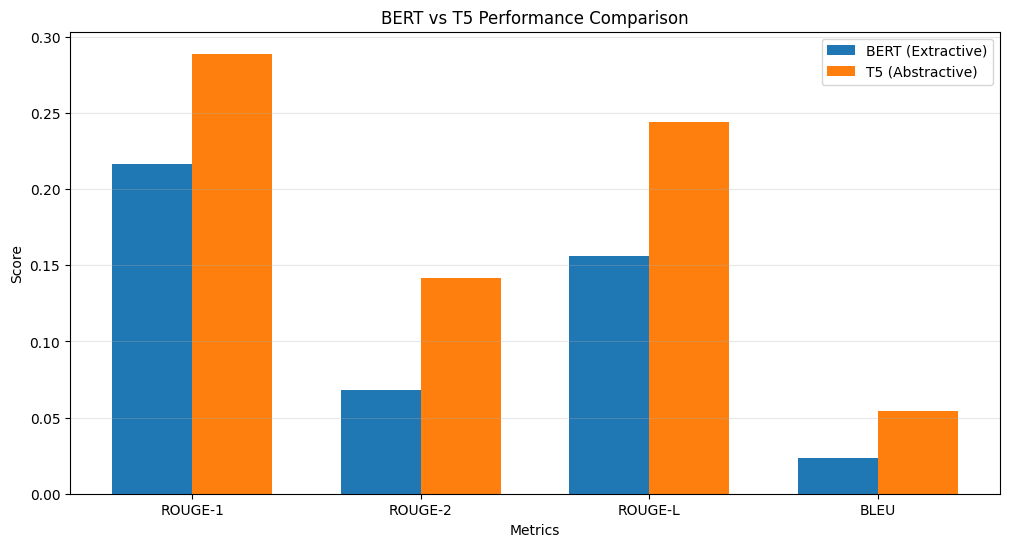

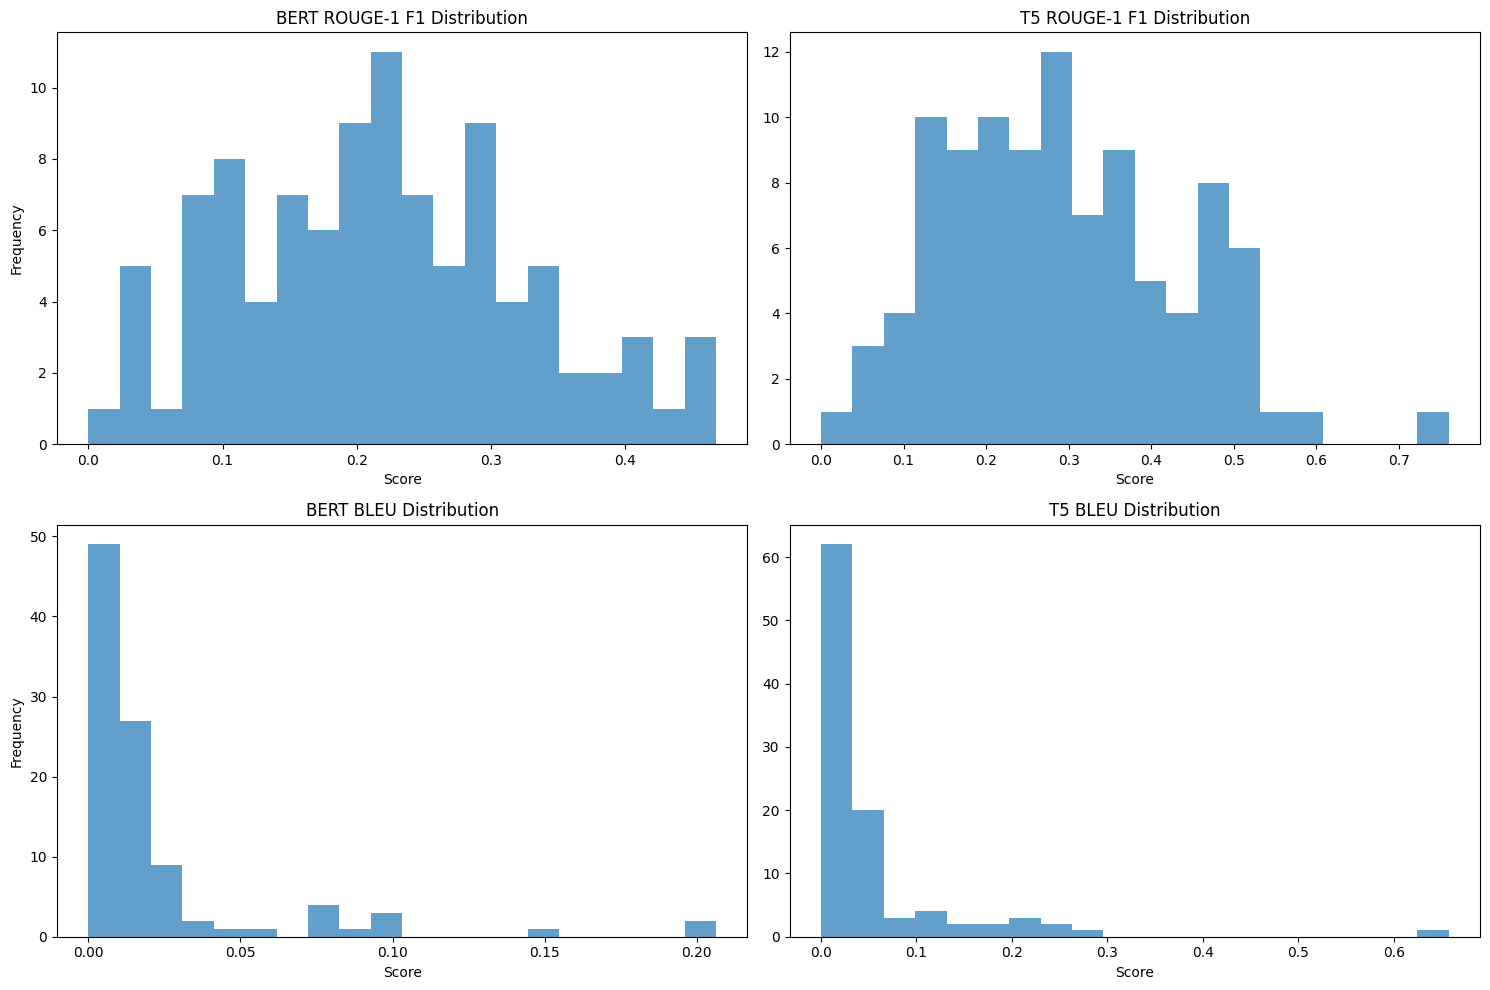


=== SAMPLE SUMMARIES ===

Example 1:
Article (excerpt): Liputan6.com, Jakarta: Meski tak berlaku surut, perpanjangan masa bakti Jenderal Polisi S. Bimantoro adalah konsekuensi dari pengesahan Rancangan Undang-undang Kepolisian, 23 Oktober mendatang. Dengan...
Reference: Jenderal Polisi S. Bimantoro tetap menjabat Kapolri hingga 2004 jika DPR mensahkan Rancangan Undang-undang Kepolisian. Pengesahan RUU Kepolisian dinilai tak mencerminkan reformasi.
BERT Summary: Hal itu diungkapkan pengamat hukum Harkristuti Harkrisnowo di Jakarta, Sabtu (20/10). Hal itu diyakini Harkristuti bakal berubah jika RUU telah disahkan DPR. Selain itu, rapat juga membahas beberapa draft penting, di antaranya terkait perubahan masa jabatan Kapolri dari 55 menjadi 58 tahun .
T5 Summary: <extra_id_0> Jenderal Polisi S. Bimantoro adalah konsekuensi dari pengesahan Rancangan Undang-undang Kepolisian, 23 Oktober mendatang.
BERT ROUGE-1 F1: 0.1212
T5 ROUGE-1 F1: 0.4390
-----------------------------------------------

In [ ]:
import torch
import os
import json
import numpy as np
from tqdm.auto import tqdm
from transformers import (
    BertTokenizer, BertConfig, BertModel,
    T5ForConditionalGeneration, AutoTokenizer
)
import torch.nn as nn
from rouge_score import rouge_scorer
import nltk
nltk.download('punkt_tab')
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import matplotlib.pyplot as plt
import pandas as pd

# Download nltk punkt untuk segmentasi kalimat
nltk.download('punkt', quiet=True)

# Path dan konfigurasi
MODEL_DIR = "/content/data/models"
DATA_DIR = "/content/data/processed_data/subset_5percent"
OUTPUT_DIR = "/content/data/evaluation_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Konfigurasi model paths
BERT_MODEL_PATH = os.path.join(MODEL_DIR, "bert_best")
T5_MODEL_PATH = os.path.join(MODEL_DIR, "t5_best")

# Konfigurasi device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Load test dataset
def load_test_data():
    print("\nLoading test data...")
    test_file = os.path.join(DATA_DIR, "test.json")

    if os.path.exists(test_file):
        with open(test_file, 'r', encoding='utf-8') as f:
            test_data = json.load(f)
        print(f"Loaded {len(test_data)} test examples")
        return test_data
    else:
        print(f"Warning: {test_file} not found")
        return []

# Class for BERT Extractive Summarization
class BertExtractor:
    def __init__(self, model_path):
        # Define a BertSummarizer class
        class BertSummarizer(nn.Module):
            def __init__(self):
                super(BertSummarizer, self).__init__()
                # Load pre-trained BERT
                self.bert = BertModel.from_pretrained("indolem/indobert-base-uncased")
                self.dropout = nn.Dropout(0.1)
                self.classifier = nn.Linear(self.bert.config.hidden_size, 1)

            def forward(self, input_ids, attention_mask=None, token_type_ids=None):
                outputs = self.bert(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids
                )

                sequence_output = outputs[0]
                pooled_output = outputs[1]

                sequence_output = self.dropout(sequence_output)
                logits = self.classifier(sequence_output).squeeze(-1)

                return logits

        # Load tokenizer
        print(f"Loading BERT tokenizer...")
        self.tokenizer = BertTokenizer.from_pretrained("indolem/indobert-base-uncased")

        # Initialize model
        print(f"Initializing BERT model...")
        self.model = BertSummarizer()

        # Try loading model weights if available
        if os.path.exists(os.path.join(model_path, "pytorch_model.bin")):
            print(f"Loading weights from {model_path}...")
            try:
                # Directly load state dict to avoid HuggingFace Hub connection
                state_dict = torch.load(os.path.join(model_path, "pytorch_model.bin"), map_location=DEVICE)
                self.model.load_state_dict(state_dict, strict=False)
                print("BERT model weights loaded successfully!")
            except Exception as e:
                print(f"Warning: Failed to load BERT weights: {e}")
                print("Using untrained BERT model for demonstration")
        else:
            print(f"Warning: No weights found at {model_path}, using untrained BERT model")

        self.model.to(DEVICE)
        self.model.eval()

    def extract_sentences(self, text, top_n=3):
        # Tokenize sentences
        sentences = nltk.sent_tokenize(text)
        if len(sentences) <= 1:
            return text

        # Add special handling for short documents
        if len(sentences) <= top_n:
            return " ".join(sentences)

        # Prepare inputs for model
        inputs = self.tokenizer(
            text,
            max_length=512,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

        # Get predictions
        with torch.no_grad():
            logits = self.model(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                token_type_ids=inputs["token_type_ids"]
            )

        # Convert sentence-level scores from token-level predictions
        # This is a simplified approach
        sentence_scores = []

        # Get scores for each sentence based on average token scores
        prev_idx = 0
        for i, sentence in enumerate(sentences):
            sentence_tokens = self.tokenizer.tokenize(sentence)

            if prev_idx + len(sentence_tokens) > 512:
                # If we exceed max length, assign a low score
                sentence_scores.append(-100)
            else:
                # Take average of token scores for this sentence
                end_idx = min(prev_idx + len(sentence_tokens), 512-1)

                # If single token, use that token's score
                if end_idx == prev_idx:
                    score = logits[0, prev_idx].item()
                else:
                    score = logits[0, prev_idx:end_idx].mean().item()

                sentence_scores.append(score)
                prev_idx = end_idx

        # Select top sentences
        top_sentence_indices = np.argsort(sentence_scores)[-top_n:]
        top_sentence_indices = sorted(top_sentence_indices)  # Keep original order

        summary = " ".join([sentences[i] for i in top_sentence_indices])
        return summary

# Class for T5 Abstractive Summarization
class T5Abstractor:
    def __init__(self, model_path):
        # Load tokenizer
        print(f"Loading T5 tokenizer...")
        self.tokenizer = AutoTokenizer.from_pretrained("panggi/t5-small-indonesian-summarization-cased")

        # Try loading model
        print(f"Loading T5 model...")
        if os.path.exists(model_path):
            try:
                self.model = T5ForConditionalGeneration.from_pretrained(model_path)
                print("T5 model loaded successfully!")
            except Exception as e:
                print(f"Warning: Failed to load T5 model: {e}")
                print("Using pre-trained panggi/t5-small-indonesian-summarization-cased for demonstration")
                self.model = T5ForConditionalGeneration.from_pretrained("panggi/t5-small-indonesian-summarization-cased")
        else:
            print(f"Warning: Path {model_path} not found, using pre-trained panggi/t5-small-indonesian-summarization-cased")
            self.model = T5ForConditionalGeneration.from_pretrained("panggi/t5-small-indonesian-summarization-cased")

        self.model.to(DEVICE)
        self.model.eval()

    def generate_summary(self, text, max_length=50, min_length=10):
        # Prepare input
        prefix = "ringkasan: "
        input_text = prefix + text

        # Tokenize
        inputs = self.tokenizer(
            input_text,
            max_length=512,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

        # Generate summary
        with torch.no_grad():
            output_ids = self.model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=max_length,
                min_length=min_length,
                num_beams=4,
                repetition_penalty=2.5,
                length_penalty=1.0,
                early_stopping=True,
                no_repeat_ngram_size=2
            )

        # Decode summary
        summary = self.tokenizer.decode(output_ids[0], skip_special_tokens=True)

        return summary

# Main evaluation function
def evaluate_models(test_data, num_samples=None):
    print("\n=== EVALUATING MODELS ON TEST SET ===")

    # Initialize models
    bert_extractor = BertExtractor(BERT_MODEL_PATH)
    t5_abstractor = T5Abstractor(T5_MODEL_PATH)

    # Initialize metrics
    rouge_calculator = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Metrics storage
    metrics = {
        'bert': {
            'rouge-1': {'p': [], 'r': [], 'f': []},
            'rouge-2': {'p': [], 'r': [], 'f': []},
            'rouge-l': {'p': [], 'r': [], 'f': []},
            'bleu': []
        },
        't5': {
            'rouge-1': {'p': [], 'r': [], 'f': []},
            'rouge-2': {'p': [], 'r': [], 'f': []},
            'rouge-l': {'p': [], 'r': [], 'f': []},
            'bleu': []
        }
    }

    # Sample predictions for analysis
    examples = []

    # Limit number of samples for evaluation
    if num_samples and num_samples < len(test_data):
        np.random.seed(42)
        indices = np.random.choice(len(test_data), num_samples, replace=False)
        test_subset = [test_data[i] for i in indices]
    else:
        test_subset = test_data

    # Evaluation loop
    for i, item in enumerate(tqdm(test_subset, desc="Evaluating")):
        article = item['clean_article']
        reference = item['clean_summary']

        try:
            # BERT extractive summary
            bert_summary = bert_extractor.extract_sentences(article)

            # T5 abstractive summary
            t5_summary = t5_abstractor.generate_summary(article)

            # Calculate ROUGE scores
            bert_rouge = rouge_calculator.score(reference, bert_summary)
            t5_rouge = rouge_calculator.score(reference, t5_summary)

            # Store ROUGE scores
            for rouge_type, score_type in [
                ('rouge1', 'rouge-1'),
                ('rouge2', 'rouge-2'),
                ('rougeL', 'rouge-l')
            ]:
                metrics['bert'][score_type]['p'].append(bert_rouge[rouge_type].precision)
                metrics['bert'][score_type]['r'].append(bert_rouge[rouge_type].recall)
                metrics['bert'][score_type]['f'].append(bert_rouge[rouge_type].fmeasure)

                metrics['t5'][score_type]['p'].append(t5_rouge[rouge_type].precision)
                metrics['t5'][score_type]['r'].append(t5_rouge[rouge_type].recall)
                metrics['t5'][score_type]['f'].append(t5_rouge[rouge_type].fmeasure)

            # Calculate BLEU score
            reference_tokens = [reference.split()]
            bert_tokens = bert_summary.split()
            t5_tokens = t5_summary.split()

            # Smooth BLEU to handle cases where no n-gram overlaps
            smooth = SmoothingFunction().method1

            try:
                bert_bleu = corpus_bleu([reference_tokens], [bert_tokens], smoothing_function=smooth)
                metrics['bert']['bleu'].append(bert_bleu)
            except:
                metrics['bert']['bleu'].append(0)

            try:
                t5_bleu = corpus_bleu([reference_tokens], [t5_tokens], smoothing_function=smooth)
                metrics['t5']['bleu'].append(t5_bleu)
            except:
                metrics['t5']['bleu'].append(0)

            # Store example for analysis
            if i < 10:  # Store first 10 examples
                examples.append({
                    'article': article,
                    'reference': reference,
                    'bert_summary': bert_summary,
                    't5_summary': t5_summary,
                    'bert_rouge1_f': bert_rouge['rouge1'].fmeasure,
                    't5_rouge1_f': t5_rouge['rouge1'].fmeasure
                })

        except Exception as e:
            print(f"Error processing item {i}: {e}")

    # Calculate average metrics
    avg_metrics = {
        'bert': {
            'rouge-1': {'p': 0, 'r': 0, 'f': 0},
            'rouge-2': {'p': 0, 'r': 0, 'f': 0},
            'rouge-l': {'p': 0, 'r': 0, 'f': 0},
            'bleu': 0
        },
        't5': {
            'rouge-1': {'p': 0, 'r': 0, 'f': 0},
            'rouge-2': {'p': 0, 'r': 0, 'f': 0},
            'rouge-l': {'p': 0, 'r': 0, 'f': 0},
            'bleu': 0
        }
    }

    for model in ['bert', 't5']:
        for rouge_type in ['rouge-1', 'rouge-2', 'rouge-l']:
            for metric in ['p', 'r', 'f']:
                avg_metrics[model][rouge_type][metric] = np.mean(metrics[model][rouge_type][metric])

        avg_metrics[model]['bleu'] = np.mean(metrics[model]['bleu'])

    # Print results
    print("\n=== EVALUATION RESULTS ===")

    print("\nBERT Extractive Summarization:")
    print(f"ROUGE-1 F1: {avg_metrics['bert']['rouge-1']['f']:.4f}")
    print(f"ROUGE-2 F1: {avg_metrics['bert']['rouge-2']['f']:.4f}")
    print(f"ROUGE-L F1: {avg_metrics['bert']['rouge-l']['f']:.4f}")
    print(f"BLEU: {avg_metrics['bert']['bleu']:.4f}")

    print("\nT5 Abstractive Summarization:")
    print(f"ROUGE-1 F1: {avg_metrics['t5']['rouge-1']['f']:.4f}")
    print(f"ROUGE-2 F1: {avg_metrics['t5']['rouge-2']['f']:.4f}")
    print(f"ROUGE-L F1: {avg_metrics['t5']['rouge-l']['f']:.4f}")
    print(f"BLEU: {avg_metrics['t5']['bleu']:.4f}")

    # Save results
    results = {
        'avg_metrics': avg_metrics,
        'metrics': metrics,
        'examples': examples
    }

    results_file = os.path.join(OUTPUT_DIR, "evaluation_results.json")
    with open(results_file, 'w', encoding='utf-8') as f:
        json.dump(results, f, ensure_ascii=False, indent=2)

    print(f"\nEvaluation results saved to {results_file}")

    # Visualization
    visualize_results(avg_metrics, metrics, examples)

    return results

# Function untuk visualisasi hasil
def visualize_results(avg_metrics, metrics, examples):
    # 1. Bar chart comparing ROUGE and BLEU scores
    plt.figure(figsize=(12, 6))

    # ROUGE F1 scores
    labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU']
    bert_scores = [
        avg_metrics['bert']['rouge-1']['f'],
        avg_metrics['bert']['rouge-2']['f'],
        avg_metrics['bert']['rouge-l']['f'],
        avg_metrics['bert']['bleu']
    ]

    t5_scores = [
        avg_metrics['t5']['rouge-1']['f'],
        avg_metrics['t5']['rouge-2']['f'],
        avg_metrics['t5']['rouge-l']['f'],
        avg_metrics['t5']['bleu']
    ]

    x = np.arange(len(labels))
    width = 0.35

    plt.bar(x - width/2, bert_scores, width, label='BERT (Extractive)')
    plt.bar(x + width/2, t5_scores, width, label='T5 (Abstractive)')

    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('BERT vs T5 Performance Comparison')
    plt.xticks(x, labels)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    # Save figure
    plt.savefig(os.path.join(OUTPUT_DIR, "model_comparison.png"))
    plt.show()

    # 2. Score distribution
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.hist(metrics['bert']['rouge-1']['f'], bins=20, alpha=0.7)
    plt.title('BERT ROUGE-1 F1 Distribution')
    plt.xlabel('Score')
    plt.ylabel('Frequency')

    plt.subplot(2, 2, 2)
    plt.hist(metrics['t5']['rouge-1']['f'], bins=20, alpha=0.7)
    plt.title('T5 ROUGE-1 F1 Distribution')
    plt.xlabel('Score')

    plt.subplot(2, 2, 3)
    plt.hist(metrics['bert']['bleu'], bins=20, alpha=0.7)
    plt.title('BERT BLEU Distribution')
    plt.xlabel('Score')
    plt.ylabel('Frequency')

    plt.subplot(2, 2, 4)
    plt.hist(metrics['t5']['bleu'], bins=20, alpha=0.7)
    plt.title('T5 BLEU Distribution')
    plt.xlabel('Score')

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "score_distributions.png"))
    plt.show()

    # 3. Sample examples table
    print("\n=== SAMPLE SUMMARIES ===")
    for i, example in enumerate(examples[:3]):  # Show first 3 examples
        print(f"\nExample {i+1}:")
        print(f"Article (excerpt): {example['article'][:200]}...")
        print(f"Reference: {example['reference']}")
        print(f"BERT Summary: {example['bert_summary']}")
        print(f"T5 Summary: {example['t5_summary']}")
        print(f"BERT ROUGE-1 F1: {example['bert_rouge1_f']:.4f}")
        print(f"T5 ROUGE-1 F1: {example['t5_rouge1_f']:.4f}")
        print("-" * 80)

    # Create and save a CSV with all examples
    examples_df = pd.DataFrame(examples)
    examples_file = os.path.join(OUTPUT_DIR, "sample_summaries.csv")
    examples_df.to_csv(examples_file, index=False)
    print(f"Sample summaries saved to {examples_file}")

# Entry point
if __name__ == "__main__":
    # Load test data
    test_data = load_test_data()

    if test_data:
        # Evaluate models (limit to 100 samples for faster evaluation)
        results = evaluate_models(test_data, num_samples=100)
        print("\n=== EVALUATION COMPLETE ===")
    else:
        print("No test data available. Evaluation cannot proceed.")